# Submesoscale processes in the ice-impacted SO

This notebook describes the analysis followed by Giddy et al. 

To start, data is called and plotted as an overview

* Linearly Interpolated Seaglider data are input (the pre-processing and interpolation will be provided in a separate notebook)
* Additional data is called from ERA5, Copernicus, Bremen, AVISO
* Some regional plots are produced - these feed into Figure 1

Then, the following analyses are performed:

* Analysis of upper ocean vertical and horizontal buoyancy
* Turner angle analysis to assess the contributions of salinity and temperature to vertical and horizontal stratification
* MLI growthrates
* Atmospheric derived equivalent heat fluxes are computed (Qnet,FWF,mesoscale EBF)
* Submesocale equivalent heat fluxes are calculated, an example of the methodology is provided
* Spectral Analysis of the mixed layer density variation 
* Spice analysis to explain cross isopycnal separation 


In [94]:
# Load modules
%matplotlib inline


import numpy as np
import os, sys
sys.path.insert(0, 'functions/')

import sms_fluxes
import gsw

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean.cm as cmo

import glidertools as gt

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes ,InsetPosition,mark_inset
import cmocean.cm as cmo

from scipy.interpolate import griddata as g


In [95]:
from matplotlib import rc
rc('font',**{'size':14})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [96]:
# Load data

In [97]:
# All data loaded with intake
import intake
cat = intake.open_catalog('giddy_2020_data.yaml')

#cat.items() #to view the data

In [453]:
# Glider data - sg643
# This data has already been interpolated
dat = cat.sg643_pressure_levels.read()

SA=(dat.salt)
CT=(dat.temp)
rho=(dat.dens)
depth=dat.depth
lat=(dat.lat[15,:])
lon=(dat.lon[15,:])
dist=(dat.distance)
glider_dir=np.array(sms_fluxes.calc_glider_traj(lat,lon)) # Glider Trajectory

In [454]:
time=pd.Series(dat.time[15,:])

In [ ]:
# Separate into transects for some analysis

import pandas as pd

df=pd.DataFrame(data={'lat':lat[:-1],'lon':lon[:-1],'rho':pd.Series(np.nanmean(rho[10:30,:-1],0)).interpolate(),'SA':SA[15,:-1]
                     })
#### I hacked this, not very efficient but it works
tr=[]
count=1
for i in range(len(df.lat)):
    
    if (np.diff(df.lat[i:i+2])<0.002)&(np.diff(df.lat[i:i+2])>-0.002)==True:
            tr.append(i)
trd=np.diff(tr)
print(tr)


tr = [120,296,350, 376,410,435,467,488,522,546, 581,608,638,668,700,722,758,782,815,
      843,876,901,940,965,997,1020,1048,1068,1110,1128,1159,1198,1220,1250,1280,
      1361,1508,1568,1596,1623,
      1697,1723,1749,1792,1824,1859,1890,1920,1945,1980,2000,2039,2074]

trd=np.diff(tr)

trans=np.zeros(120)


for i,j in enumerate(trd):
    trans=np.concatenate((trans,(np.ones(j)*i+1)))

print(len(trans))
df['trans']=np.int8(trans)

In [100]:
# Load auxillary data

In [101]:
# ERA5

# Winds - ERA5
era5_winds=cat.era5_winds.read()
era5w_subset=era5_winds.sel(latitude=-60,longitude=0)

#Heat fluxes
# Load annual cycle heat flux
era5_annual = cat.era5_heat.read()
latent=era5_annual.mslhf.mean(dim='latitude').mean(dim='longitude')
longwave=era5_annual.msnlwrf.mean(dim='latitude').mean(dim='longitude')
shortwave=era5_annual.msnswrf.mean(dim='latitude').mean(dim='longitude')
sensible=era5_annual.msshf.mean(dim='latitude').mean(dim='longitude')
Qnet = latent+longwave+shortwave+sensible

#Freshwater Fluxes
erafw = cat.era5_fw.read()
erafw=erafw.sel(latitude=-60.0,longitude=0)
fwfms = (erafw.mer+erafw.mtpr)/3600  # convert to seconds


In [9]:
# Sea Ice
ds_si=xr.open_mfdataset('data/seaice/asi*.nc',combine='nested',concat_dim='time')
coords=xr.open_dataset('data/seaice/LongitudeLatitudeGrid-s6250-Antarctic.hdf',engine='pynio')
ln = coords.Longitudes.values
lt = coords.Latitudes.values

In [10]:
datadir='data/'
ls = os.listdir(os.path.join(datadir,'seaice'))
ls.sort()
sic_date=[]
for filename in ls:
    if filename[-2:] == 'nc':
        try:
            sic_date.append(pd.to_datetime(str(filename)[-14:-5]))
        except: 'Value Error', sic_date.append(pd.to_datetime(str(filename)[-16:-8]))
sic_date=pd.Series(sic_date)

seaice=ds_si.ASI_Ice_Concentration

print('starting interpolation')
X = np.arange(-180 ,180, 0.05)
Y = np.arange(-80, -49.95, 0.05)
x, y = np.meshgrid(X,Y)
sic_new = np.ndarray([len(seaice.time), len(Y), len(X)])
print(sic_date[348])

i=348
print('ravelling')
x_, y_ = np.ravel(ln), np.ravel(lt)
x_[x_>180] = x_[x_>180]-360
print('ravelling sea ice')
si = np.ravel(seaice[i,:,:])
print(si.shape)
print('doing the interpolation')
sic_new[i,:,:] = g((y_, x_), si, (y, x), method='linear')
sic_new[sic_new==0] = np.NaN

# identify indices of seaice at roammiz site
ind=np.array(np.where((lt>-61)&(lt<-59)&(ln>-1)&(ln<1)))


starting interpolation
2018-12-15 00:00:00
ravelling
ravelling sea ice
(1678592,)
doing the interpolation


In [12]:
# Sentinal 3A, Chl sat OCLI
chl=cat.chla.read()

In [439]:
# AVISO

avisoAn=xr.open_dataset('data/aviso/aviso_annual.nc')
aviso2=xr.open_dataset('data/aviso/aviso_2018_2019.nc')

#avisoAn=avisoAn.sel(latitude=-60.125,longitude=360.125)
adt=aviso2.sel(latitude=slice(-65,-55),longitude=slice(-5,5))

In [13]:
# SMOS satellite Sea Surface Salinity
smos = cat.sss.read()

/Users/isabelle/opt/anaconda3/lib/python3.7/site-packages/intake_xarray/netcdf.py:58: FutureWarning:

In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi


/Users/isabelle/opt/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning:

Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, pl

## Regional Setting

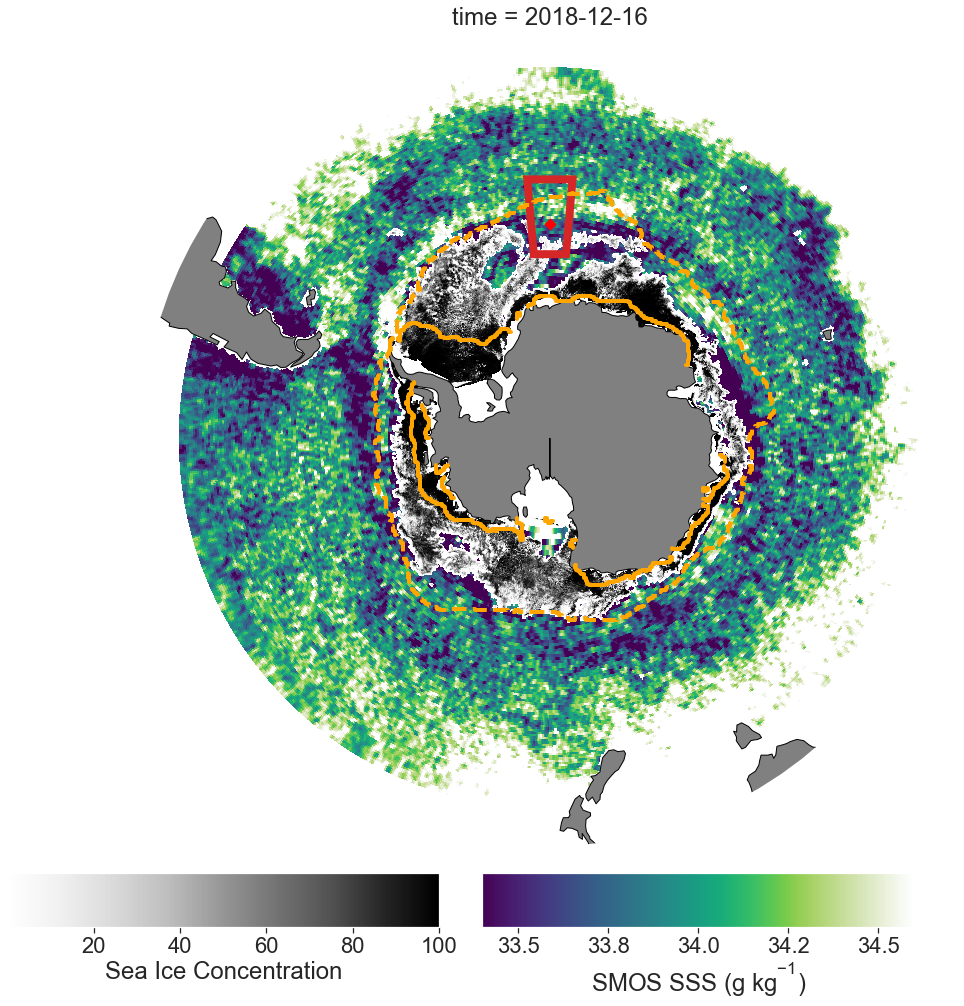

In [15]:
### SMOS Figure

from obspy.imaging.cm import viridis_white
import seaborn as sns
import cartopy
import cartopy.crs as ccrs

import matplotlib
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapefile   
from mpl_toolkits.axes_grid1.inset_locator import inset_axes ,InsetPosition,mark_inset

import matplotlib.path as mpath
import cmocean.cm as cmo

sns.set(font_scale=2)

# Load sea ice extent poplygons

fname1 = r'data/seaice/seaice_extent/extent_S_201809_polyline_v3.0.'
fname2 = r'data/seaice/seaice_extent/extent_S_201902_polyline_v3.0.'

projection =ccrs.SouthPolarStereo(central_longitude=0) # set projection

fig, ax = plt.subplots(1, figsize=(15,15),
                       subplot_kw={'projection': projection})

# SMOS SSS data
cs=smos.sel(time='2018-12-16',lat=slice(-83.517136,-40.131504)).SSS.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),vmin=33.4,vmax=34.6,cmap=viridis_white,add_colorbar=False)
cax = fig.add_axes([0.45, 0.05, 0.4, 0.05])
cbar=plt.colorbar(cs,cax=cax,orientation='horizontal',format='%.1f',shrink=0.5)
cbar.set_label('SMOS SSS (g kg$^{-1}$)')


#Ice
cf=ax.pcolormesh(X,Y,sic_new[348,:,:], transform=ccrs.PlateCarree(),cmap='Greys')
cax = fig.add_axes([0.01, 0.05, 0.4, 0.05])
cbar2=plt.colorbar(cf,cax=cax,orientation='horizontal',format='%.0f',shrink=0.5)
cbar2.set_label('Sea Ice Concentration')

#Sea Ice extent 
# Max Extent 2018
sf = shapefile.Reader(fname1)
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        listx = [i[0] for i in shape.shape.points[i_start:i_end]]
        listy = [i[1] for i in shape.shape.points[i_start:i_end]]
        ax.plot(listx,listy,transform=ccrs.SouthPolarStereo(),c='orange', linestyle='--',linewidth=4,label='Max Sea Ice Extent')

# Min Extent 2019
sf = shapefile.Reader(fname2)
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        listx = [i[0] for i in shape.shape.points[i_start:i_end]]
        listy = [i[1] for i in shape.shape.points[i_start:i_end]]
        ax.plot(listx,listy,transform=ccrs.SouthPolarStereo(),c='orange',linestyle='-',linewidth=4,label='Min Sea Ice Extent')


# Study site
ax.add_patch(mpatches.Rectangle(xy=[-5, -64], width=10, height=10,
                                    facecolor='None',edgecolor='tab:red',linewidth=8,
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))

ax.scatter(0,-60,c='red',s=60,marker='D', transform=ccrs.PlateCarree())


# Some edits to the plot
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='Grey')

theta = np.linspace(0, 2*np.pi, 100)   # Make plot a circle
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
ax.outline_patch.set_visible(False)

plt.savefig('figures/map2018_smos_v6.png',bbox_inches='tight',transparent=True,dpi=100)

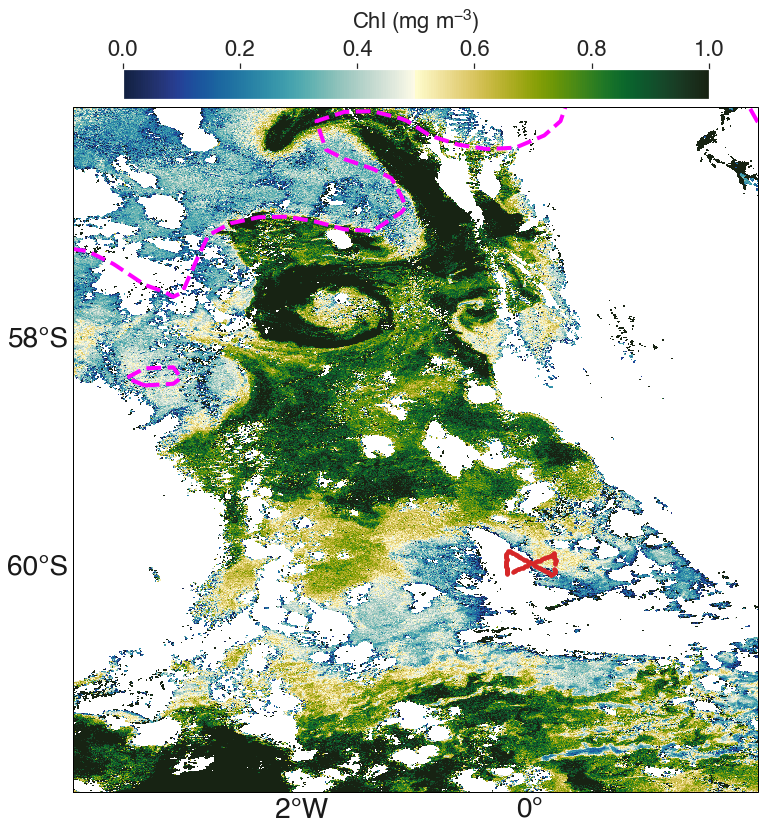

In [16]:
## Figure 1b - Chl
### Chlorophyll

import matplotlib
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':22})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


projection =ccrs.PlateCarree()#
data_crs=ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(15,15),
                       subplot_kw={'projection': projection})

ax.set_extent([-4, 2, -62, -56])

# Chl data
chlnorm=chl.CHL_OC4ME
z = np.ma.masked_where(chlnorm <= 0, chlnorm)
cs=ax.pcolormesh(chl.longitude,chl.latitude,z,vmin=0, vmax=1,cmap=cmo.delta,transform=data_crs)

cax,kw = matplotlib.colorbar.make_axes(ax,location='top',pad=0.01,shrink=0.7)
out=fig.colorbar(cs,cax=cax,**kw)
label=out.set_label('Chl (mg m$^{-3}$)',size=22,verticalalignment='bottom')

# Seaglider location
ax.scatter(lon[522:644],lat[522:644],facecolor='tab:red',s=12,transform=data_crs)

# Location of the Southern Boundary of the ACC
ax.contour(adt.longitude,adt.latitude,adt.adt[38,:,:], levels=[-1.244],colors='magenta',linestyles='--',transform=data_crs,linewidths=4)

# Plot cleaning
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-4, -2, 0, 2,4])
gl.ylocator = mticker.FixedLocator([-62, -60, -58, -56,-54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 28, 'color': 'k'}
gl.ylabel_style = {'size': 28, 'color': 'k'}

plt.savefig('figures/chl_summer_2018_v3.png',transparent=True,dpi=100,bbox_inches='tight')


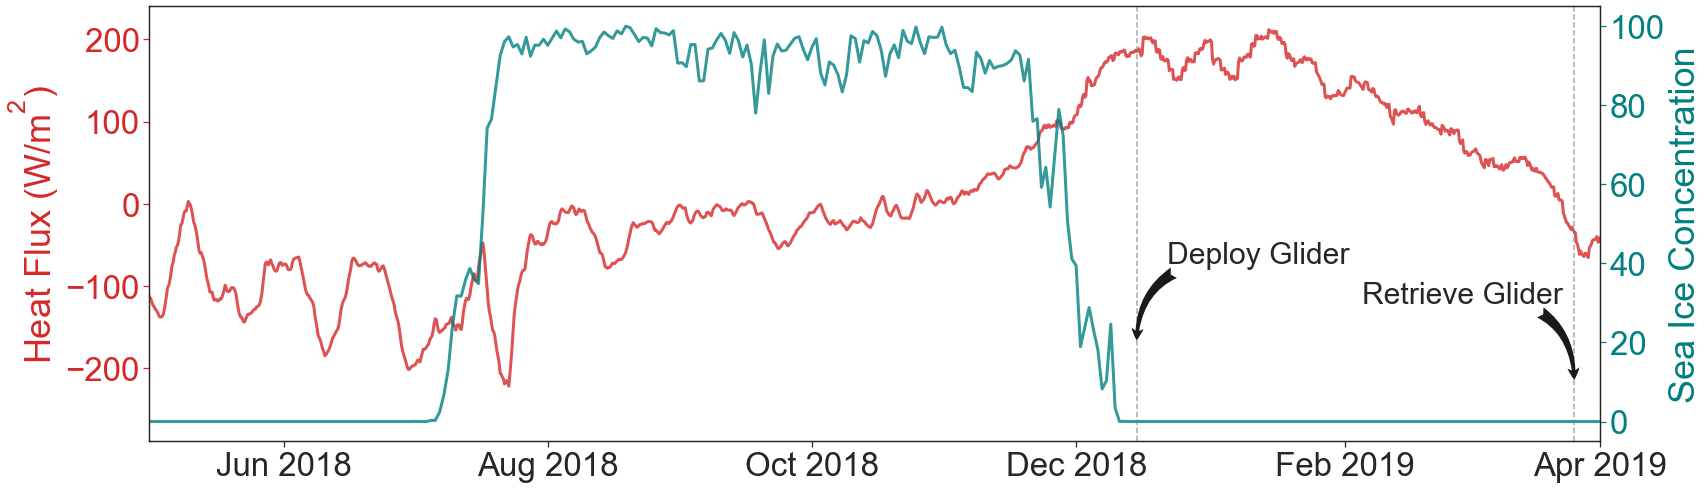

In [15]:
# Seasonality

import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=[26,8],sharex=True)
sns.set(font_scale=3)


sns.set_style('white')
sns.set(font_scale=3)
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 20})


#heat flux
ax.plot(era5_annual.time,pd.Series(Qnet).rolling(24).mean(),c='tab:red',linewidth=3,alpha=0.8)
ax.set_ylabel('Heat Flux (W/m$^2$)',c='tab:red')
ax.tick_params(axis='y', colors='tab:red')

#seaice
ax3=ax.twinx()
ax3.plot(sic_date,np.nanmean(np.nanmean(seaice[:,ind[0],ind[1]],axis=1),axis=1),c='teal',linewidth=3,alpha=0.8)
ax3.set_ylabel('Sea Ice Concentration',c='teal')

ax3.tick_params(axis='y', colors='teal')

ax3.set_xlim(np.array(avisoAn.time[30]),np.array(avisoAn.time[-1]))


ax3.axvline(np.array(avisoAn.time[258]),c='Grey',linestyle='--',alpha=0.7) # Start deployment
ax3.axvline(np.array(avisoAn.time[359]),c='Grey',linestyle='--',alpha=0.7) # End deployment


# Mark start and end of deployment
ax3.annotate('Deploy Glider', xy=(np.array(avisoAn.time[258]),20),  xycoords='data',
            xytext=(np.array(avisoAn.time[265]),40),fontsize=30,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax3.annotate('Retrieve Glider', xy=(np.array(avisoAn.time[359]),10),  xycoords='data',
            xytext=(np.array(avisoAn.time[310]),30),fontsize=30,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

# Plot formatting
months = mdates.MonthLocator(interval=2, tz=None)
ax.xaxis.set_major_locator(months)
h_fmt= mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(h_fmt)

plt.savefig('figures/sg643_fig1_seasonality.png',transparent=True,dpi=75,bbox_inches='tight')


In [462]:
np.nanmean(np.sqrt(adt.vgos[10,20,:50]**2+adt.ugos[10,20,:50]**2))

0.07755174798526675

## Vertical and Horizontal Buoyancy

In [102]:
## Put this somewhere

# Distance of glider sample site from Southern Boundary
import gsw as gsw
gsw.distance([0,0],[-60,-56])/1000

array([444.77970658])

In [103]:
lat_point=-60
f = sms_fluxes.coriolis_acc(np.nanmean(lat_point)) # Coriolis Acceleration

alpha,beta= sms_fluxes.alphabeta(SA,CT,depth) #Thermal Expansion Coeffient and Saline Contraction Coefficient

mld = pd.Series(sms_fluxes.calc_mld(np.array(rho),np.array(depth),ref_depth=10))  #Mixed Layer Depth

Buoyancy (kindof the inverse of density) is defined as

$$
b _x = g(1-\rho/\rho_0)
$$



In [104]:
by=(9.8*(1-(rho[:]/1027)))

Buoyancy including salinity and temperature contributions
$$
b_x=g\alpha \frac {\delta T} {\delta x} - g\beta \frac {\delta S} {\delta x}
$$

In [105]:

g=9.8
by=(9.8*(1-(rho[:]/1027)))
b=g*alpha[:,:-1]*np.diff(CT,axis=1)-g*beta[:,:-1]*np.diff(SA,axis=1)
bT=g*alpha[:,:-1]*CT.diff(dim='distance')   # Temperature contribution
bS=g*beta[:,:-1]*SA.diff(dim='distance')    # Salinity contribution
bgrad=np.diff(by)/1000

# average lateral buoyancy gradient in the mixed layer (at least 15m above the ML)
bxml=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    bxml[i]=(np.nanmean(bgrad[:np.int8(mld[i])-15,i],0))
    
bxml=pd.Series(bxml).interpolate()

# point lateral buoyancy gradient in the middle of the ML
bxmd=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    bxmd[i]=bgrad[np.int8(mld[i]/2),i]
    
bxmd=pd.Series(bxmd).interpolate()

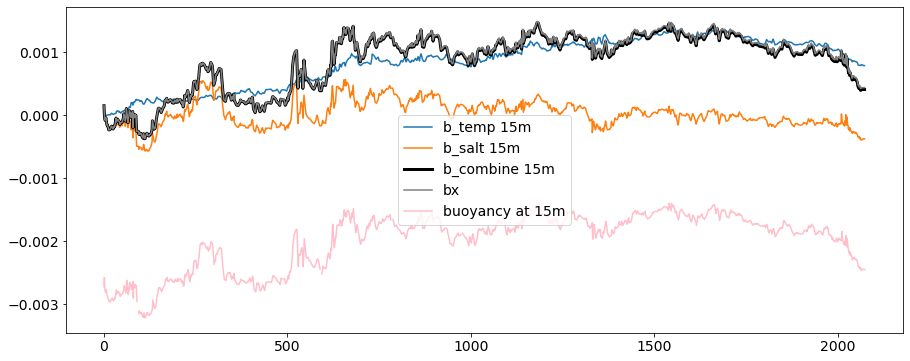

In [14]:
# Checking the decomposition algorithm

plt.figure(figsize=[15,6])
plt.plot(np.nancumsum(bT[15,:]),label='b_temp 15m')
plt.plot(np.nancumsum(-bS[15,:]),label='b_salt 15m')
plt.plot(np.nancumsum(bT[15,:])-(np.nancumsum(bS[15,:])),c='k',linewidth=3,label='b_combine 15m')
plt.plot(np.nancumsum(bgrad[15,:]*1000),c='Grey',label='bx')

plt.plot((by[15,:]),c='pink',label='buoyancy at 15m')
plt.legend()




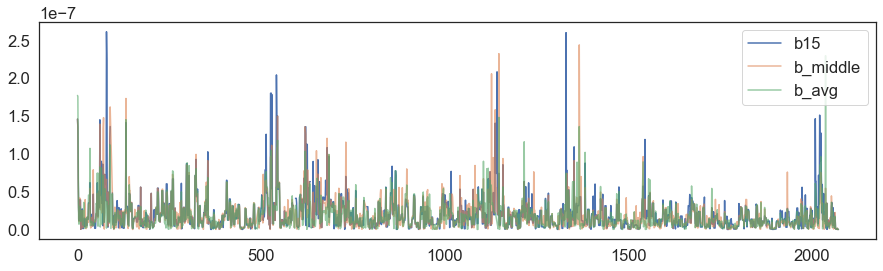

In [124]:
# Difference between ML buoyancy gradient choices

plt.figure(figsize=[15,4])
plt.plot(np.abs(bgrad[15,:]),label='b15')
plt.plot(np.abs(bxmd[:]),alpha=0.6,label='b_middle')
plt.plot(np.abs(bxml),alpha=0.6,label='b_avg')
plt.legend()
#plt.savefig('figures/bx_comparison.png',bbox_inches='tight',dpi=75)


Vertical stratification is defined by the Brunt Vaisala frequency

$$
N^2 = \delta b / \delta z 
$$

It can be separated into temperature and salinity components

$$
N^2_T = g\alpha \frac {\delta T} {\delta z} 
$$

$$
N^2_S = N^2 - N^2_T
$$

In [33]:
# Vertical Stratification

import gsw
import pandas as pd
_,y=np.meshgrid(dist,depth)

n2 = np.diff(by,axis=0)*-1
n2_t=(g*alpha[:-1,:]*np.diff(CT,axis=0))*-1   # Temperature component
n2_S=(g*beta[:-1,:]*np.diff(SA,axis=0)*-1)   # Temperature component



n2_s = n2-n2_t # Salt component

# ML N2
# Total
n2ml=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    n2ml[i]=(np.nanmean(n2[(np.int8(mld[i])-5):np.int8(mld[i])+5,i],0))
    
n2ml=pd.Series(n2ml).interpolate()

# Temperature component
n2mlT=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    n2mlT[i]=(np.nanmean(n2_t[np.int8(mld[i])-5:np.int8(mld[i])+5,i],0))
    
n2mlT=pd.Series(n2mlT).interpolate()

# Salinity component
n2mlS=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    n2mlS[i]=(np.nanmean(n2_s[np.int8(mld[i])-5:np.int8(mld[i])+5,i],0))
    
n2mlS=pd.Series(n2mlS).interpolate()


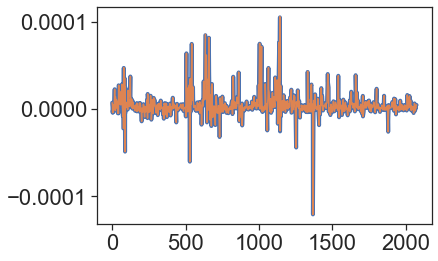

In [34]:
plt.plot(n2[15,:],lw=4)
plt.plot(n2_t[15,:]-n2_S[15,:])

Text(<xarray.DataArray 'distance' ()>
array(1320000)
Coordinates:
    distance  int64 1320000, -10, 'N-S transect')

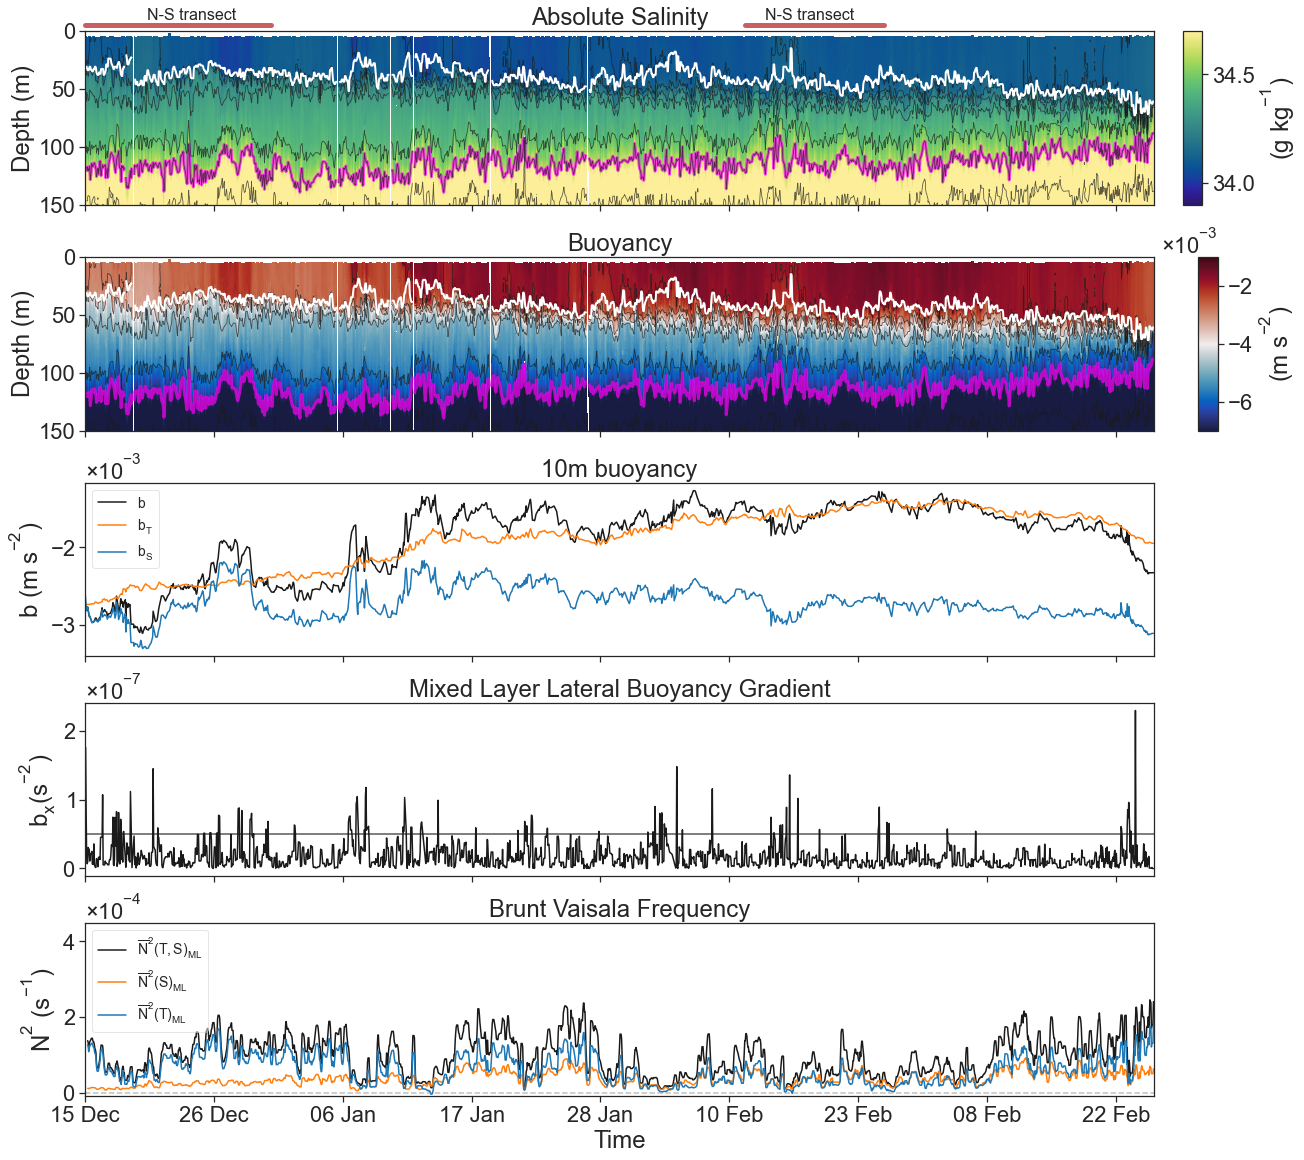

In [35]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from matplotlib import pyplot, lines
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

fig,ax=plt.subplots(5,1,figsize=[18,16],sharex=True,constrained_layout=True)

ax[0].set_title('Absolute Salinity')
x,y=np.meshgrid(dist,depth)
cs=ax[0].pcolormesh(x,y,SA,cmap=cmo.haline,vmin=33.9,vmax=34.7)
ax[0].contour(x,y, rho,levels=[1027.7],colors='magenta',linewidths=3,alpha=0.7)



cbar=plt.colorbar(cs,ax=ax[0],aspect=10)
cbar.set_label('(g kg$^{-1}$)')
levels=np.arange(1027,1028,0.1)
ax[0].contour(x,y, rho,levels=levels,colors='k',linewidths=0.8,alpha=0.7)
ax[0].plot(dist[:],pd.Series(mld).rolling(3).median(),c='w',linewidth=2)

ax[0].set_ylim(150,0)
ax[0].set_ylabel('Depth (m)')

ax[1].set_title('Buoyancy')
x,y=np.meshgrid(dist,depth)
cs=ax[1].pcolormesh(x,y,by,cmap=cmo.balance,vmin=-0.007,vmax=-0.001)
cbar=plt.colorbar(cs,ax=ax[1],aspect=10,pad=0.001)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter._useMathText = True


cbar.update_ticks()
cbar.set_label('(m s$^{-2})$')
levels=np.arange(1027,1028,0.1)
ax[1].contour(x,y, rho,levels=levels,colors='k',linewidths=0.8,alpha=0.7)
ax[1].plot(dist[:],pd.Series(mld).rolling(3).median(),c='w',linewidth=2)
ax[1].contour(x,y, rho,levels=[1027.7],colors='magenta',linewidths=3,alpha=0.7)

ax[1].set_ylabel('Depth (m)')


ax[1].set_ylim(150,0)

ax[2].set_title('10m buoyancy')

ax[2].plot(dist[:-1],(np.array(by[15,0])+np.nancumsum(bT[15,:])-(np.nancumsum(bS[15,:]))),c='k',label=u'$b$')#'\\\rho_0$')
ax[2].plot(dist[:-1],(np.array(by[15,0])+np.nancumsum(bT[15,:])),c='tab:orange',label=u'$b_T$')
ax[2].plot(dist[:-1],(np.array(by[15,0])+np.nancumsum(-bS[15,:])),c='tab:blue',label=u'$b_S$')

ax[2].legend(loc='best',framealpha=0.5,fontsize=14)
formatter = ticker.ScalarFormatter(useMathText=True)

ax[2].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax[2].yaxis.major.formatter._useMathText = True

ax[2].set_ylabel('b (m $s^{-2})$')

ax[3].set_title('Mixed Layer Lateral Buoyancy Gradient')
ax[3].axhline(0.5e-7, c='Gray',linewidth=2)
ax[3].plot(dist[:-1],np.abs(bxml),c='k')

ax[3].set_ylabel('$b_x (s^{-2})$')
ax[3].ticklabel_format(axis='y', style='sci', scilimits=(-7,-7))
ax[3].yaxis.major.formatter._useMathText = True

ax[4].set_title('Brunt Vaisala Frequency')
ax[4].plot(dist[:-1],pd.Series(n2ml).rolling(6).median(),c='k',label='$\overline{N}{^2}(T,S)_{ML}$')
ax[4].plot(dist[:-1],pd.Series(n2mlT).rolling(6).median(),c='tab:orange',label='$\overline{N}{^2}(S)_{ML}$')
ax[4].plot(dist[:-1],pd.Series(n2mlS).rolling(6).median(),c='tab:blue',label='$\overline{N}{^2}(T)_{ML}$')

ax[4].axhline(0,c='Grey',alpha=0.5,linestyle='--')
ax[4].legend(loc='upper left',framealpha=0.5,fontsize=14)
ax[4].set_ylim(-1e-5,4.5e-4)
ax[4].set_ylabel('$N^2$ $(s^{-1})$')
ax[4].set_xticks([0,250000, 500000,750000, 1000000,1250000,1500000,1750000,2000000])  # this is a bit of a hack 
ax[4].set_xticklabels(['15 Dec','26 Dec','06 Jan','17 Jan','28 Jan',
                       '10 Feb','23 Feb','08 Feb','22 Feb'])

ax[4].set_xlabel('Time')

ax[4].ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
ax[4].yaxis.major.formatter._useMathText = True
ax[4].set_xlim(dist[0],dist[-1])


# Add lines to show mesoscale transects
x,y = np.array([[0, dist[360]], [-5, -5]])
line = lines.Line2D(x, y, lw=5., color='r', alpha=0.9)
ax[0].add_line(line)
line.set_clip_on(False)

x,y = np.array([[dist[1280], dist[1550]], [-5, -5]])
line = lines.Line2D(x, y, lw=5., color='r', alpha=0.9)
ax[0].add_line(line)
line.set_clip_on(False)

ax[0].text(dist[120],-10,'N-S transect',fontsize=16)
ax[0].text(dist[1320],-10,'N-S transect',fontsize=16)

#plt.savefig('figures/buoyancy_summer_2018_v5.png',transparent=True,dpi=75,bbox_inches='tight')



## Turner Angle Analysis

The verticle turner angle defined as:

$$
Tu = \arctan(R_p)
$$

where 
$$
Rp = \alpha \frac {\delta T} {\delta z} (\beta \frac {\delta S} {\delta z})^{-1}
$$


Similarly, the horizontal turner angle is defined by replacing the vertical gradient with the horizontal:

$$
Rp_{horizontal} = \alpha \frac {\delta T} {\delta x} (\beta \frac {\delta S} {\delta x})^{-1}
$$







In [17]:
# vertical
Rpx=(alpha[:-1,:]*(np.diff(CT,axis=0))/(beta[:-1,:]*(np.diff(SA,axis=0))))
Tux=(np.arctan(Rpx))

# Lateral
RpxL=(alpha[:,:-1]*(np.diff(CT,axis=1)/1000)/(beta[:,:-1]*(np.diff(SA,axis=1)/1000)))
TuxL=pd.Series((np.arctan(RpxL[15,:]))).interpolate()

(-1.5707963267948966, 1.5707963267948966)

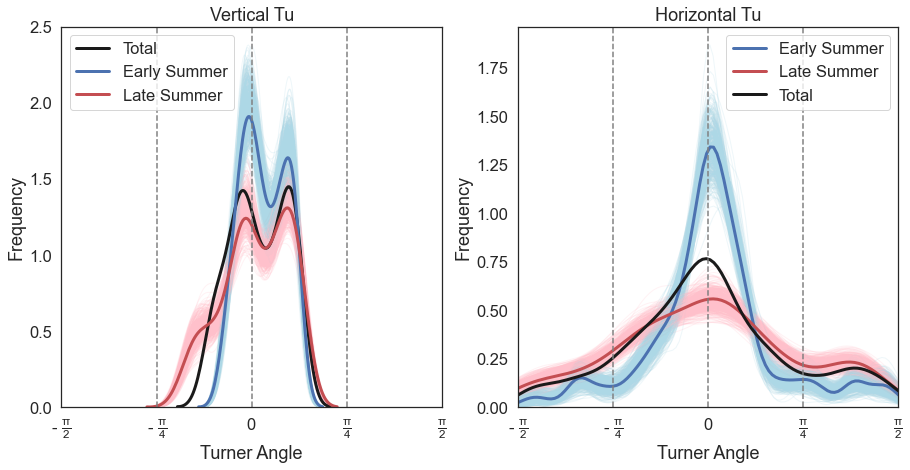

In [18]:
import seaborn as sns
sns.set(font_scale=1.5)

sns.set_style('white')
sns.set_color_codes()


bins = np.linspace(-np.pi/2,np.pi/2, 20)

fig,ax=plt.subplots(1,2,figsize=[15,7])
ax[0].set_title('Vertical Tu')


summer_subset=pd.Series(np.nanmean(Tux[10:200,10:490],axis=1)).interpolate()
sample = np.random.choice(summer_subset, size=300) 


lsummer_subset=pd.Series(np.nanmean(Tux[10:200,1467:1857],axis=1)).interpolate()
sample2 = np.random.choice(lsummer_subset, size=300) 


# Added confidence interval using bootstrapping
for _ in range(500):  #so B=10000
    sample_n = np.random.choice(summer_subset, size=300)
    sample_n2 = np.random.choice(lsummer_subset, size=300)


    sns.distplot(pd.Series((sample_n)), hist=False, bins=bins,rug=False,kde_kws={"color": "lightblue", "lw": 1,'alpha':0.2},ax=ax[0])
    sns.distplot(pd.Series((sample_n2)), hist=False,bins=bins, rug=False,kde_kws={"color": "pink", "lw": 1,'alpha':0.2},ax=ax[0])

sns.distplot(pd.Series(np.nanmean(Tux[10:200,:],axis=1)).interpolate(), hist=False,bins=bins ,rug=False,label='Total',kde_kws={"color": "k", "lw": 3},ax=ax[0])

sns.distplot(pd.Series(np.nanmean(Tux[10:200,10:490],axis=1)).interpolate(), hist=False, bins=bins,rug=False,label='Early Summer',kde_kws={"color": "b", "lw": 3},ax=ax[0])
sns.distplot(pd.Series(np.nanmean(Tux[10:200,1467:1857],axis=1)).interpolate(), hist=False,bins=bins, rug=False,label='Late Summer',kde_kws={"color": "r", "lw": 3},ax=ax[0])
ax[0].axvline(x=-np.pi/4,c='Gray',linestyle='--')
ax[0].axvline(x=np.pi/4,c='Gray',linestyle='--')
ax[0].axvline(x=0,c='Gray',linestyle='--')

ax[0].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4,np.pi/2])
ax[0].set_xticklabels([r'- $\frac{\pi}{2}$',r'- $\frac{\pi}{4}$','$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Turner Angle')
ax[0].set_xlim(-np.pi/2,np.pi/2)

ax[1].set_title('Horizontal Tu')

bins = np.linspace(-np.pi/2,np.pi/2,20)


summer_subset=TuxL[10:390]
sample = np.random.choice(summer_subset, size=300) 

lsummer_subset=TuxL[1467:1857]
sample2 = np.random.choice(lsummer_subset, size=300) 


for _ in range(500):  #so B=10000
    sample_n = np.random.choice(summer_subset, size=300)
    sample_n2 = np.random.choice(lsummer_subset, size=300)


    sns.distplot(pd.Series((sample_n)), hist=False, bins=bins,rug=False,kde_kws={"color": "lightblue", "lw": 1,'alpha':0.2},ax=ax[1])
    sns.distplot(pd.Series((sample_n2)), hist=False,bins=bins, rug=False,kde_kws={"color": "pink", "lw": 1,'alpha':0.2},ax=ax[1])

sns.distplot(pd.Series((summer_subset)), hist=False, bins=bins,rug=False,label='Early Summer',kde_kws={"color": "b", "lw": 3},ax=ax[1])
sns.distplot(pd.Series((lsummer_subset)), hist=False,bins=bins, rug=False,label='Late Summer',kde_kws={"color": "r", "lw": 3},ax=ax[1])


sns.distplot(pd.Series((TuxL[:])), hist=False,bins=bins, rug=False,label='Total',kde_kws={"color": "k", "lw": 3},ax=ax[1])


ax[1].axvline(x=-np.pi/4,c='Gray',linestyle='--')
ax[1].axvline(x=np.pi/4,c='Gray',linestyle='--')
ax[1].axvline(x=0,c='Gray',linestyle='--')
ax[1].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4,np.pi/2])            
ax[1].set_xticklabels(
           [r'- $\frac{\pi}{2}$',r'- $\frac{\pi}{4}$','$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[1].set_xlabel('Turner Angle')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(-np.pi/2,np.pi/2)

#plt.savefig('figures/Tu_summer_2018.png',transparent=True,dpi=75,bbox_inches='tight')

In [479]:
#Ekman Depth
np.sqrt(2*0.1/-f)

39.79888636383489

## ABI Growth Rate Analysis


Richardson number - gives idea of isopycnal slope steepness

$$
Ri = \frac {N^2} {(\delta u / \delta z)^2} \equiv \frac {f^2 N^2} {b_x^2}
$$

The fastest lengthscale and  growth rate following Stone 1970; Fox-Kemper et al. 2008, is defined as:

$$
l_{max} = \frac {2 \pi U} {f} \sqrt {\frac {1+Ri} {5/2}}$$  where 

$$
U \equiv \frac {|b_x|} f H
$$


$$
\tau_{max} = \sqrt {\frac {54} 5} \frac {\sqrt  {1+Ri}} {f}
$$


In [200]:
# Richardson number
Ri = (1.26e-4**2*np.abs(n2[:,:-1]))/np.abs(bgrad[:-1,:])**2

#Ri in the ML
riml=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    riml[i]=(np.nanmean(Ri[:np.int8(mld[i]),i],0))
riml[1705:1780]=np.nan
riml[-10:]=np.nan
riml[650:700]=np.nan
riml[1250:1500]=np.nan

logRi=np.log(np.abs(riml))
Ri_adj=logRi[logRi!=np.inf] #adjusted to exclude nans and infs


In [191]:
Ri_o1 = (1.26e-4**2*n2[15,:-1])/np.abs(bgrad[15,:])**2

In [241]:
count=0   #how many profiles have Ri < 4 
for i in range(2074):
    if Ri_o1[i]<4:
        count += 1
        
print(count/2074)

In [211]:
# Length scale 
L1=(2*np.pi*mld[:-1]*np.abs(bgrad[15,:])/f)/f*np.sqrt((1+np.abs(Ri_o1))/(5/2))
L=(2*np.pi*40*(10e-7)/f)/f*np.sqrt((1+np.abs(1))/(5/2))

# Wavelength with Ri=1
Lfk=(2*np.pi*100*np.abs(2*f**2)/f)/f*np.sqrt((1+np.abs(1))/(5/2))
print('Wavenumber:',Lfk/1000)

# Growth rate
Time= np.sqrt(54/5)*np.sqrt(1+abs(Ri_o1))/np.abs(f)
Time=Time[Time!=np.inf]

# Growth rate with Ri = 1
Time2= np.sqrt(54/5)*np.sqrt(1+1)/np.abs(f)
print('Growthrate:',Time2/3600)

Wavenumber: 1.1239703569665163
Growthrate: 10.224362037036078


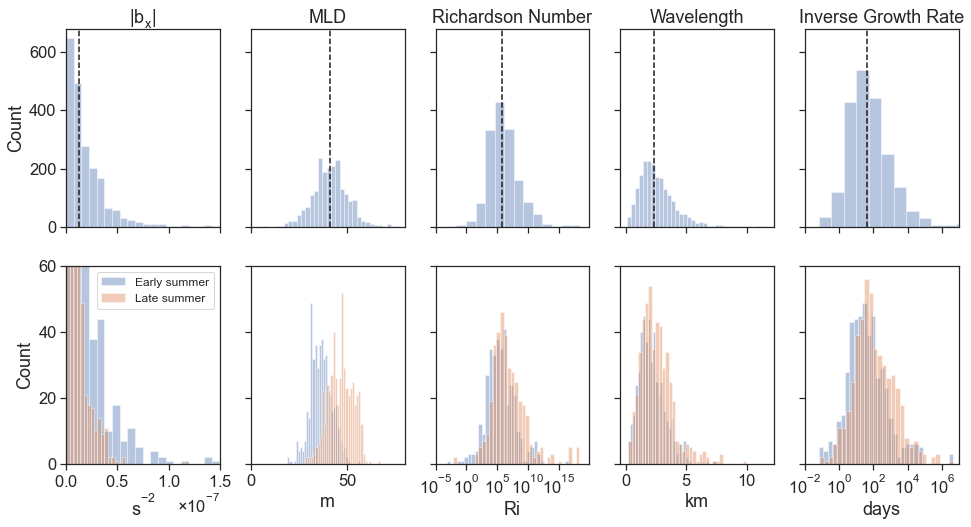

In [476]:
# Alternative Figure 7
import numpy
import seaborn as sns

fig,ax=plt.subplots(2,5,figsize=[16,8],sharex='col',sharey='row')
#plt.subplots_adjust(wspace=0.1)

 # This is buggy
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

############################



ax[0,0].set_title('|b$_x$|')


sns.distplot(np.abs(bgrad[15,:]),
             hist=True,bins=35,rug=False,label='Total',kde=False,norm_hist=False,ax=ax[0,0])
ax[0,0].axvline(np.nanmedian(np.abs(bgrad[15,:])),c='k',linestyle='--')
ax[0,0].set_xlim(0,1.5e-7)

ax[0,0].set_ylabel('Count')




sns.distplot(np.abs(bgrad[15,:])[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,0],label='Early summer')
sns.distplot(np.abs(bgrad[15,:])[1450:1950],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,0],label='Late summer')

ax[1,0].set_xlim(0,1.5e-7)
ax[1,0].set_ylim(0,60)



ax[1,0].set_ylabel('Count')


ax[1,0].legend(fontsize=12)

ax[1,0].set_xlabel('s$^{-2}$')

ax[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax[1,0].xaxis.major.formatter._useMathText = True


############################

ax[0,1].set_title('MLD')

sns.distplot(np.abs(mld), hist=True,bins=35,rug=False,label='Total',kde=False,norm_hist=False,ax=ax[0,1])
ax[0,1].axvline(np.nanmedian(np.abs(mld)),c='k',linestyle='--')
ax[0,1].set_xlim(0,80)


sns.distplot(np.abs(mld[mld!=np.nan][10:490]), 
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,1])
sns.distplot(np.abs(mld[mld!=np.nan][1450:1950]),
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,1])

ax[1,1].set_xlabel('m')


############################

ax[0,2].set_title('Richardson Number')

sns.distplot(np.log(Ri_o1[Ri_o1!=np.inf]),
             hist=True,bins=35,rug=False,label='Total',kde=False,norm_hist=False,ax=ax[0,2])
ax[0,2].axvline(np.nanmedian(np.log(Ri_o1[Ri_o1!=np.inf])),c='k',linestyle='--')
ax[0,2].set_xlim(-5,20)

sns.distplot(np.log(Ri_o1[Ri_o1!=np.inf])[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,2])
sns.distplot(np.log(Ri_o1[Ri_o1!=np.inf])[1450:1950], 
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,2])

ax[1,2].set_xlim(-5,20)

ax[1,2].set_xticks([-5,0,5,10,15])
                
ax[1,2].set_xticklabels(
           [r'$10^{-5}$',r'$10^{0}$',r'$10^5$','$10^{10}$','$10^{15}$'])

ax[1,2].set_xlabel('Ri')


############################

ax[0,3].set_title('Wavelength')


sns.distplot(L1[L1<500000]/1000,
             hist=True,bins=35,norm_hist=False,rug=False,label='Total',kde=False,ax=ax[0,3])
ax[0,3].axvline(np.nanmedian(L1/1000),c='k',linestyle='--')

sns.distplot((L1[L1<500000]/1000)[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,3])
sns.distplot((L1[L1<500000]/1000)[1450:1950],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,3])

ax[1,3].set_xlabel('km')

############################

ax[0,4].set_title('Inverse Growth Rate')

sns.distplot(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400),
             hist=True,bins=35,norm_hist=False,rug=False,label='Total',kde=False,ax=ax[0,4])
ax[0,4].axvline(np.nanmedian(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400)),
                c='k',linestyle='--')
ax[0,4].set_xlim(-2,7)

sns.distplot(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400)[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,4])
sns.distplot(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400)[1450:1950],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,4])

ax[1,4].set_xticks([-2,0,2,4,6])
                
ax[1,4].set_xticklabels(
           [r'$10^{-2}$',r'$10^0$','$10^2$', r'$10^4$', r'$10^6$'])


ax[1,4].set_xlabel('days')

############################


plt.savefig('figures/histograms.png',bbox_inches='tight',dpi=75)

In [130]:
# Length scale 
L1=(2*np.pi*mld[:-1]*np.abs(bxml)/f)/f*np.sqrt((1+np.abs(riml))/(5/2))
L=(2*np.pi*40*(10e-7)/f)/f*np.sqrt((1+np.abs(1))/(5/2))

# Wavelength with Ri=1
Lfk=(2*np.pi*100*np.abs(2*f**2)/f)/f*np.sqrt((1+np.abs(1))/(5/2))
print('Wavenumber:',Lfk/1000)

# Growth rate
Time= np.sqrt(54/5)*np.sqrt(1+abs(riml))/np.abs(f)
Time=Time[Time!=np.inf]

# Growth rate with Ri = 1
Time2= np.sqrt(54/5)*np.sqrt(1+1)/np.abs(f)
print('Growthrate:',Time2/3600)


Wavenumber: 1.1239703569665163
Growthrate: 10.224362037036078


In [131]:
# Compare to BFK 2008
#h ~ 100 m
# bx ~ 2f^2
2*(f**2)

3.188645999999999e-08

## Atmospheric derived surface fluxes

In [106]:
# Q is given in W/m2
Qnet_interp=sms_fluxes.glider_compat(era5_annual.time,time,Qnet) # Interpolated to glider track


To convert freshwater flux from m/s to an equivalent heat flux, first FWF is converted to a buoyancy:

$$
F_b = (E-P)  \times \beta \times g \times S
$$

and then converted to an equivalent heat flux

$$
Q_{FWF} = \frac {F_b \times \rho_0 \times C_p}  {\alpha \times g}
$$


In [107]:
#  FWF computation
fwf_interp=sms_fluxes.glider_compat(erafw.time,time,fwfms) # Interpolated to glider track
F_b=fwf_interp*beta[10,:]*g*pd.Series(SA[15,:]).interpolate()
Qnet_F=(F_b*(1027*4000)/(alpha[10,:]*g))

In [108]:
Qsurf = Qnet_interp+Qnet_F

In [109]:
tau, tau_x, tau_y, wind_dir = sms_fluxes.calc_wind(era5w_subset.u10[:,0],era5w_subset.v10[:,0]) # Wind Stress
tx_interp=pd.Series(sms_fluxes.glider_compat(era5w_subset.time,time,tau_x)).rolling(1).mean() # Interpolated to glider track
ty_interp=pd.Series(sms_fluxes.glider_compat(era5w_subset.time,time,tau_y)).rolling(1).mean()
wind_dir_interp=pd.Series(sms_fluxes.glider_compat(era5w_subset.time,time,wind_dir)).rolling(1).mean()

In [110]:
print('mean wind stress:',np.nanmean(np.sqrt(tx_interp**2+ty_interp**2)))

mean wind stress: 0.09213216467490348


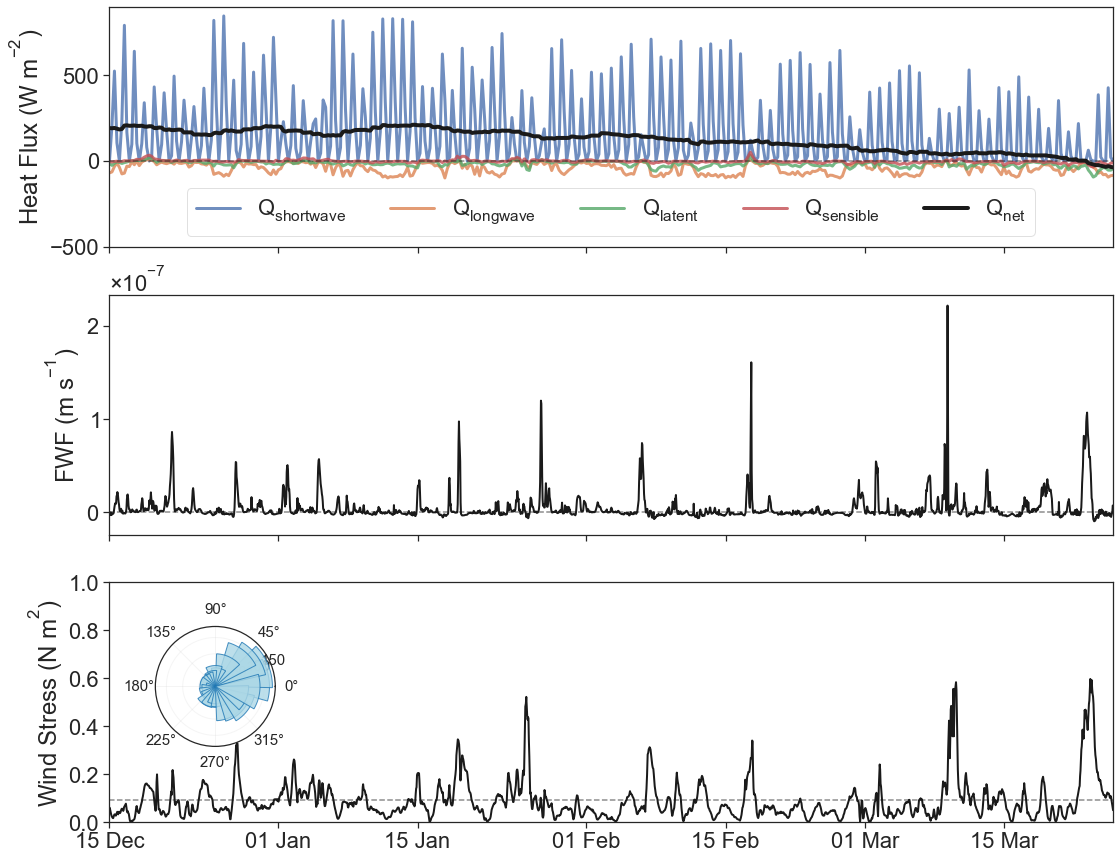

In [111]:
import seaborn as sns
fig,ax=plt.subplots(3,1,figsize=[18,15],sharex=True)
sns.set(font_scale=2)

sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class


#heat flux
ax[0].plot(era5_annual.time,era5_annual.msnswrf[:,2,4],label='Q$_{shortwave}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,era5_annual.msnlwrf[:,2,4],label='Q$_{longwave}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,era5_annual.mslhf[:,2,4],label='Q$_{latent}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,era5_annual.msshf[:,2,4],label='Q$_{sensible}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,pd.Series(era5_annual.mslhf[:,2,4]+era5_annual.msshf[:,2,4]
                                      +era5_annual.msnswrf[:,2,4]+era5_annual.msnlwrf[:,2,4]).rolling(24).mean()
                                       ,c='k',linewidth=4,label='Q$_{net}$')
ax[0].legend(loc='lower center',framealpha=0.6,ncol=6)
ax[0].axhline(0,c='k',linestyle='--',alpha=0.5)
ax[0].set_ylim(-500,900)
ax[0].set_ylabel('Heat Flux (W m$^{-2}$)')

# Freshwater Flux
ax[1].plot(erafw.time,(erafw.mer+erafw.mtpr)/3600,c='k',linewidth=2)
ax[1].axhline(0,c='k',linestyle='--',alpha=0.5)
ax[1].ticklabel_format(axis='y',style='sci',scilimits=(-7,7))
ax[1].yaxis.major.formatter._useMathText = True
ax[1].set_ylabel('FWF (m s$^{-1}$)')

# Winds
ax[2].plot(time,np.sqrt(tx_interp**2+ty_interp**2),c='k',linewidth=2)
ax[2].axhline(np.nanmean(np.sqrt(tx_interp**2+ty_interp**2)),c='k',linestyle='--',alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_ylabel('Wind Stress (N m$^{2}$)')
ax[2].set_xlim(time.iloc[0],time.iloc[-1])
h_fmt= mdates.DateFormatter('%d %b')
ax[2].xaxis.set_major_formatter(h_fmt)

# Wind direction inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins=inset_axes(ax[2],width="170%", height="50%",
                 axes_class = matplotlib.projections.get_projection_class('polar'),
                 borderpad=2
)

normalise = pd.Series((wind_dir_interp+ 360) % 360).interpolate()   # First normalise winds from -180-180 to 0-360, interpolate over nans

histogram, bins = np.histogram(np.deg2rad(normalise), bins=25)
bin_centers = 0.5*(bins[1:] + bins[:-1])
axins.bar(bin_centers, histogram,label="Wind Orientation",
          color='lightblue',bottom=0.0,alpha=0.8,edgecolor='tab:blue')
axins.grid(alpha=0.2) 
axins.yaxis.get_major_locator().base.set_params(nbins=5)

axins.tick_params(labelsize=15)

plt.savefig('figures/sg643_atmospheric_conditions.png',bbox_inches='tight',dpi=75)

Text(0.5, 0, 'Longitude')

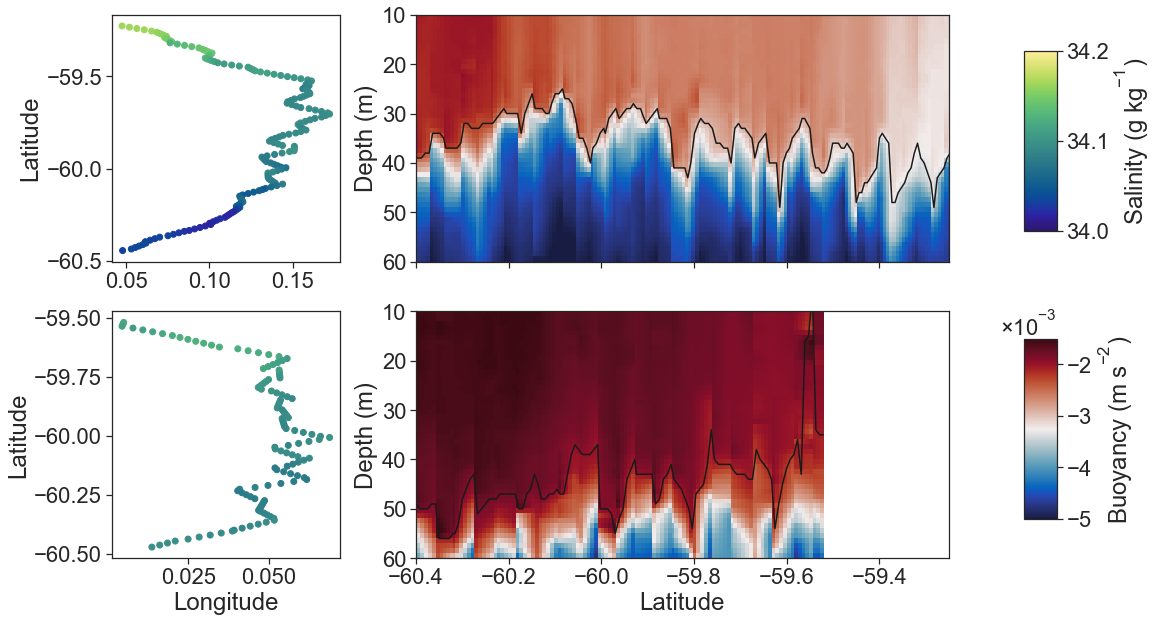

In [32]:
# Mesoscale Ekman Buoyancy Flux

# Overview of mesoscale transects
fig = plt.figure(constrained_layout=False,figsize=[15,10])
gs = gridspec.GridSpec(2, 2, figure=fig,width_ratios=[0.3,0.7])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[0,0])
ax4 = plt.subplot(gs[1,0])

cs1=ax3.scatter(lon[120:290],lat[120:290],c=SA[15,120:290],cmap=cmo.haline,vmin=34.0,vmax=34.2)
xx,yy=np.meshgrid(pd.Series(lat[120:290]).interpolate(),pd.Series(depth).interpolate())
ax1.pcolormesh(xx,yy,by[:,120:290],cmap=cmo.balance,vmin=-5e-3,vmax=-1.5e-3)


ax1.set_ylim(60,10)
ax1.set_xlim(-60.4,-59.25)
ax1.plot(lat[120:290],mld[120:290],c='k')

ax4.scatter(lon[1365:1485],lat[1365:1485],c=SA[15,1365:1485],cmap=cmo.haline,vmin=34.0,vmax=34.2)
xx,yy=np.meshgrid(lat[1365:1485],depth)


cs=ax2.pcolormesh(xx,yy,by[:,1365:1485],cmap=cmo.balance,vmin=-5e-3,vmax=-1.5e-3)
ax2.set_ylim(60,10)
ax2.set_xlim(-60.4,-59.25)
ax2.plot(lat[1365:1485],mld[1365:1485],c='k')

cax = fig.add_axes([0.97, 0.58, 0.03, 0.25])
cax2 = fig.add_axes([0.97, 0.18, 0.03, 0.25])

cbar1=plt.colorbar(cs1,cax=cax)
cbar2=plt.colorbar(cs,cax=cax2)

cbar1.set_label('Salinity (g kg$^{-1}$)')
cbar2.set_label('Buoyancy (m s$^{-2}$)')

cbar2.formatter.set_powerlimits((0, 0))
cbar2.formatter._useMathText = True

ax1.set_xticklabels([])

ax3.set_ylabel('Latitude')
ax4.set_ylabel('Latitude')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Depth (m)')
ax1.set_ylabel('Depth (m)')

ax4.set_xlabel('Longitude')


#plt.savefig('figures/mesocale_transects.png',bbox_inches='tight',dpi=75)

In [1767]:
fwf_interp

array([-6.75251464e-10,  2.04069061e-12, -1.01341322e-09, ...,
        6.56936806e-09,  6.56936806e-09,  6.56936806e-09])

In [1835]:
Salinity_fwf=(fwf_interp*pd.Series(SA[15,:]).interpolate())/mld
np.nanmean(Salinity_fwf[:-1][df.trans==36])

3.1222423489612726e-09

The following computes the salinity component of Ekman Transport converted to an equivalent heat flux (taken from Pellichero et al., 2017)

$$
dS_{Ekman}/dt = U_e . \nabla S_m 
$$

where, 

$$
U_e =\frac 1 {\rho_o f H} {\tau^y}
$$



In [ ]:
Ue = (1/(1027*f*np.nanmean(mld[:-1][df.trans==1])))*0.09
print(Ue)

Text(0.5, 0, 'lon')

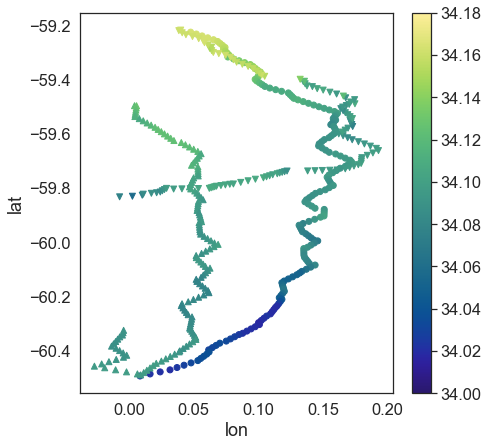

In [1831]:
# Visualize mesoscale transects

plt.figure(figsize=[7,7])
plt.scatter(df.lon[df.trans==1],df.lat[df.trans==1],c=df.SA[df.trans==1],cmap=cmo.haline,vmin=34.0,vmax=34.18)
#plt.scatter(df.lon[df.trans==0],df.lat[df.trans==0],c=df.SA[df.trans==0],marker='v',cmap=cmo.haline,vmin=34.0,vmax=34.18)
plt.scatter(df.lon[df.trans==36],df.lat[df.trans==36],c=df.SA[df.trans==36],marker='^',cmap=cmo.haline,vmin=34.0,vmax=34.18)

plt.colorbar()
plt.ylabel('lat')
plt.xlabel('lon')

In [1834]:
distance_grad_M2 = gsw.distance([df.lon[df.trans==36].iloc[-5],df.lon[df.trans==36].iloc[5]],[df.lat[df.trans==36].iloc[-5],df.lat[df.trans==36].iloc[5]])
print(distance_grad_M2)

nablaS = (np.nanmean(df.SA[df.trans==36].iloc[-5:])-np.nanmean(df.SA[df.trans==36].iloc[:5]))/distance_grad_M2

nablaS*Ue


[92129.78545692]
-0.03451751644836065
[-3.74661856e-07]


array([-7.40690201e-09])

In [1818]:
distance_grad = gsw.distance([df.lon[df.trans==0].iloc[-5],df.lon[df.trans==0].iloc[5]],[df.lat[df.trans==0].iloc[-5],df.lat[df.trans==0].iloc[5]])
distance_grad

array([64033.50050038])

In [1819]:
nablaS = (np.nanmean(df.SA[df.trans==0].iloc[-5:])-np.nanmean(df.SA[df.trans==0].iloc[:5]))/distance_grad
(np.nanmean(df.SA[df.trans==1].iloc[-5:])-np.nanmean(df.SA[df.trans==1].iloc[:5]))
nablaS

array([1.32741041e-06])

In [1820]:
nablaS*Ue

array([2.62423267e-08])

In [1821]:
(4.35128476e-08 +2.62423267e-08)/2

3.487758715e-08

In [1816]:
Ue = 1/(1027*1.23e-4*np.nanmean(mld[120:249]))*0.09
Ue

0.019769565232472232

In [1779]:
Ue = (1/(1027*f*np.nanmean(mld[:-1][df.trans==1])))*0.1

Ue

4.9410744122999075e-05

In [1717]:
# Mesoscale Transect 1
i=220
j= 270

nablaSx = (np.nanmean(SA[15,i+10])-np.nanmean(SA[15,j+10]))/(30*1000)
#print(nablaSx)
#Ue = 1/(1027*f*np.nanmean(mld[i:j]))*np.nanmean(tau_rotated[i:j]) 
Ue = 1/(1027*f*np.nanmean(mld[i:j]))*0.1

es1 = nablaSx*Ue
print(es1)


#print(es1*86400*365)
#(np.nanmean(SA[15,i+10])-np.nanmean(SA[15,j+10]))

6.486964430267466e-11


In [1718]:
# Mesoscale Transect 2

i=1380
j=1430

nablaSx2 = ((np.nanmean(SA[15,i+20])-np.nanmean(SA[15,j+20]))/(30*1000))

#Ue = 1/(1027*f*np.nanmean(mld[i:j]))*np.nanmean(tau_rotated[i:j]) 
Ue2 = 1/(1027*f*np.nanmean(mld[i:j]))*0.1
print(nablaSx2)

es2 = nablaSx2*Ue2
print(es2)
print(es2*86400*365)



7.651058737370894e-07
3.068613282843235e-11
0.0009677178848774426


In [1706]:
# Compared to FWF
Salinity_fwf=(fwf_interp*pd.Series(SA[15,:]).interpolate())/mld
np.nanmean(Salinity_fwf[:200])

6.805267654579189e-09

## Submesoscale Heat Flux Calculations 

Submesoscale Ekman Buoyancy Flux defined by Thomas et al 2005

$$
Q_{EBF} = \frac {-b_x \tau _y} {f} \frac {C_p} {\alpha g}
$$

In [112]:

ebf,ty,angle = sms_fluxes.calc_ebf(pd.Series(bxml).interpolate(),wind_dir_interp[:-1],glider_dir[:],
                          tx_interp[:-1],ty_interp[:-1],f,alpha[10,:-1],cp=4000,g=9.8) 

Submesoscale MLE as in Fox-Kemper et al 2008

$$
Q_{MLE} = 0.06 \frac {b_x^2 H^2} {f} \frac  {C_p \rho _0} {\alpha g}
$$

In [126]:
# Use 4km rolling mean to equate the heat flux to the mesoscale field

Qmle = sms_fluxes.calc_qmle(pd.Series(bxml[:]).rolling(8).mean().interpolate(),pd.Series(mld[:-1]).interpolate(),alpha[10,:-1],f) # Equivalent Heat flux from mixed layer eddies


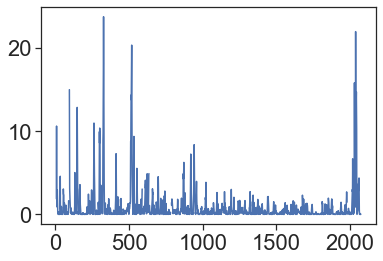

In [127]:
plt.plot(Qmle)

In [125]:
np.nanmean(Qmle[Q])

1.555821761121304

In [123]:
np.nanstd(Qmle)

3.839542807017816

### example methodology



/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


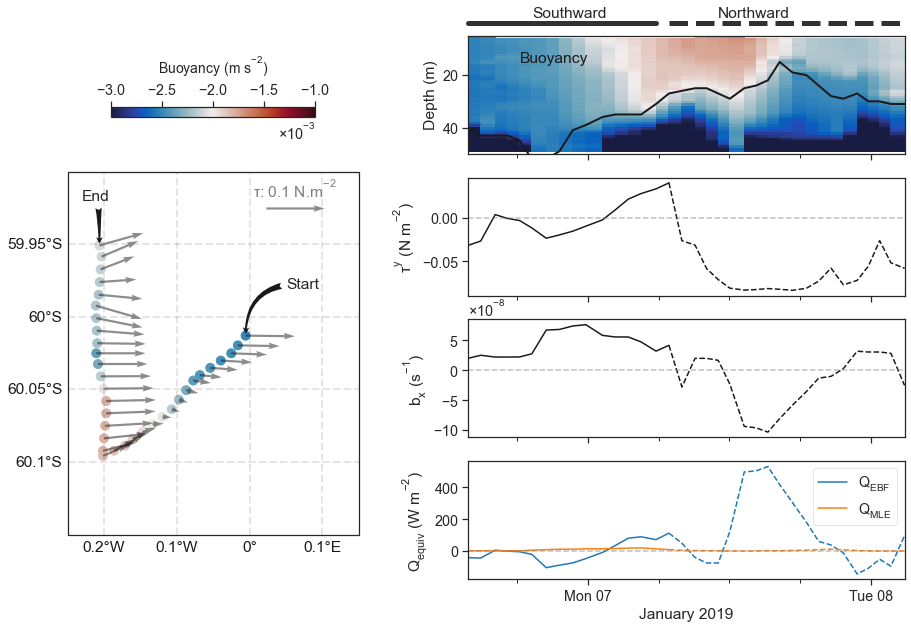

In [35]:
#500: Summer subset
import seaborn as sns
sns.set(font_scale=1.3)
from matplotlib import pyplot, lines

import cartopy
import cartopy.crs as ccrs

import matplotlib
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapefile   
from mpl_toolkits.axes_grid1.inset_locator import inset_axes ,InsetPosition,mark_inset

import matplotlib.path as mpath
import cmocean.cm as cmo


sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig = plt.figure(constrained_layout=False,figsize=[15,10])
gs = gridspec.GridSpec(4, 2, figure=fig,width_ratios=[0.4,0.6])
plt.subplots_adjust(wspace=0.3)
projection =ccrs.Mercator()#
data_crs=ccrs.PlateCarree()
ax1 = plt.subplot(gs[:,0],projection=projection)
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,1])
ax5 = plt.subplot(gs[3,1])

# Select interval
i = 505
j = 540

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cs=ax1.scatter(lon[i:j],lat[i:j],c=by[15,i:j],s=80,vmin=-3e-3,vmax=-1e-3,cmap=cmo.balance,transform=data_crs) #buoayncy

cax,kw = matplotlib.colorbar.make_axes(ax1,location='top',pad=0.1,shrink=0.7)
out=fig.colorbar(cs,cax=cax,**kw)
label=out.set_label('Buoyancy (m s$^{-2}$)',size=14,verticalalignment='bottom')

out.formatter.set_powerlimits((0, 0))
out.formatter._useMathText = True
out.update_ticks()

Q=ax1.quiver(np.array(lon[i:j]),np.array(lat[i:j]),np.array(tx_interp[i:j]),np.array(ty_interp[i:j]),alpha=0.5,scale=0.5,transform=data_crs)

qk = ax1.quiverkey(Q, 0.78, 0.90, 0.1, r'$\tau$: 0.1 N.m$^{-2}$', labelpos='N',
                 coordinates='axes',labelcolor='Grey',alpha=0.5)  # quiver key

# Clean up map
ax1.set_extent([-0.25, 0.15, -60.15, -59.9])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-0.3,-0.2, -0.1,0, 0.1,0.2])
gl.ylocator = mticker.FixedLocator([-60.15,-60.1,-60.05, -60, -59.95,-59.9])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.xlabel_style = {'color': 'k'}

gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'color': 'k'}

ax1.set_ylabel('Longitude ($^o$E)')
ax1.set_xlabel('Latitude ($^o$N)')


transform = ccrs.PlateCarree()._as_mpl_transform(ax1)

# Add annotations
ax1.annotate('Start', xy=(lon[505],lat[505]),  xycoords=transform,
            xytext=(0.05,-59.98),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax1.annotate('End', xy=(lon[539],lat[539]),  xycoords=transform,
            xytext=(-.23,-59.92),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

################################################

# Buoyancy

x,y=np.meshgrid(np.array(time[505:540]),depth[:50])
cs=ax2.pcolormesh(x,y,by[:50,505:540],vmin=-3e-3,vmax=-1e-3,cmap=cmo.balance)

ax2.plot(time[505:540],mld[505:540],c='k',lw='2')
ax2.set_ylim(50,5)
ax2.set_ylabel('Depth (m)')

# Add annotation to show northward and southward transects

a=pd.to_datetime(np.array(time[505:540]))
x,y = np.array([[(a[0]), (a[14])], [0.24, 0.24]])
line = lines.Line2D(x, y, lw=5., color='k', alpha=0.9)
ax2.add_line(line)
line.set_clip_on(False)

x,y = np.array([[(a[15]), (a[34])], [0.24, 0.24]])
line = lines.Line2D(x, y, lw=5., linestyle='--',color='k', alpha=0.9)
ax2.add_line(line)
line.set_clip_on(False)

ax2.text(a[5],-2,'Southward')
ax2.text(a[19],-2,'Northward')

ax2.text(a[4],15,'Buoyancy',color='k')

################################################
# Rotated winds

ax3.plot(time[505:521],ty[505:521],c='k')
ax3.plot(time[520:540],ty[520:540],c='k',linestyle='--',)
ax3.axhline(0,c='Grey',alpha=0.5,linestyle='--')
ax3.set_ylabel(r'$\tau^y$ (N m$^{-2}$)')

################################################
# Lateral Buoyancy Gradient
ax4.plot(time[505:521],bxml[505:521],c='k',linestyle='-')
ax4.plot(time[520:540],bxml[520:540],c='k',linestyle='--')

ax4.ticklabel_format(axis='y',style='sci',scilimits=(-8,8))
ax4.yaxis.major.formatter._useMathText = True

ax4.ticklabel_format(axis='y', style='sci', scilimits=(-8,-8))
ax4.yaxis.major.formatter._useMathText = True

ax4.axhline(0,c='Grey',alpha=0.5,linestyle='--')
ax4.set_ylabel('b$_x$ (s$^{-1}$)')

################################################
# SMS fluxes

ax5.plot(time[505:521],ebf[505:521],c='tab:blue',linestyle='-',label='$Q_{EBF}$')
ax5.plot(time[520:540],ebf[520:540],c='tab:blue',linestyle='--')

ax5.plot(time[505:521],Qmle[505:521],c='tab:orange',linestyle='-',label='$Q_{MLE}$')
ax5.plot(time[520:540],Qmle[520:540],c='tab:orange',linestyle='--')

#ax5.set_xlim(np.array(time[505]),np.array(time[539]))
ax5.axhline(0,c='Grey',alpha=0.5,linestyle='--')

ax5.legend(loc='best',framealpha=0.5)
ax5.set_ylabel('Q$_{equiv}$ (W m$^{-2}$)')


# Clean up xticks

h_fmt= mdates.DateFormatter('%a %d')
ax5.xaxis.set_major_formatter(h_fmt)
days = mdates.DayLocator( interval=1, tz=None)
ax5.xaxis.set_major_locator(days)
hours = mdates.HourLocator(byhour=[0,6,12,18,24], interval=1, tz=None)
ax5.xaxis.set_minor_locator(hours)
ax5.set_xlabel('January 2019')




ax5.set_xlim(time[505],time[539])

ax2.set_xlim(time[505],time[539])
ax3.set_xlim(time[505],time[539])
ax4.set_xlim(time[505],time[539])

ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_minor_locator(hours)
ax3.xaxis.set_major_locator(days)
ax3.xaxis.set_minor_locator(hours)
ax4.xaxis.set_major_locator(days)
ax4.xaxis.set_minor_locator(hours)


ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])


plt.savefig('figures/sms_summer_2018_subset_v3.png',transparent=True,dpi=75,bbox_inches='tight')



### Total

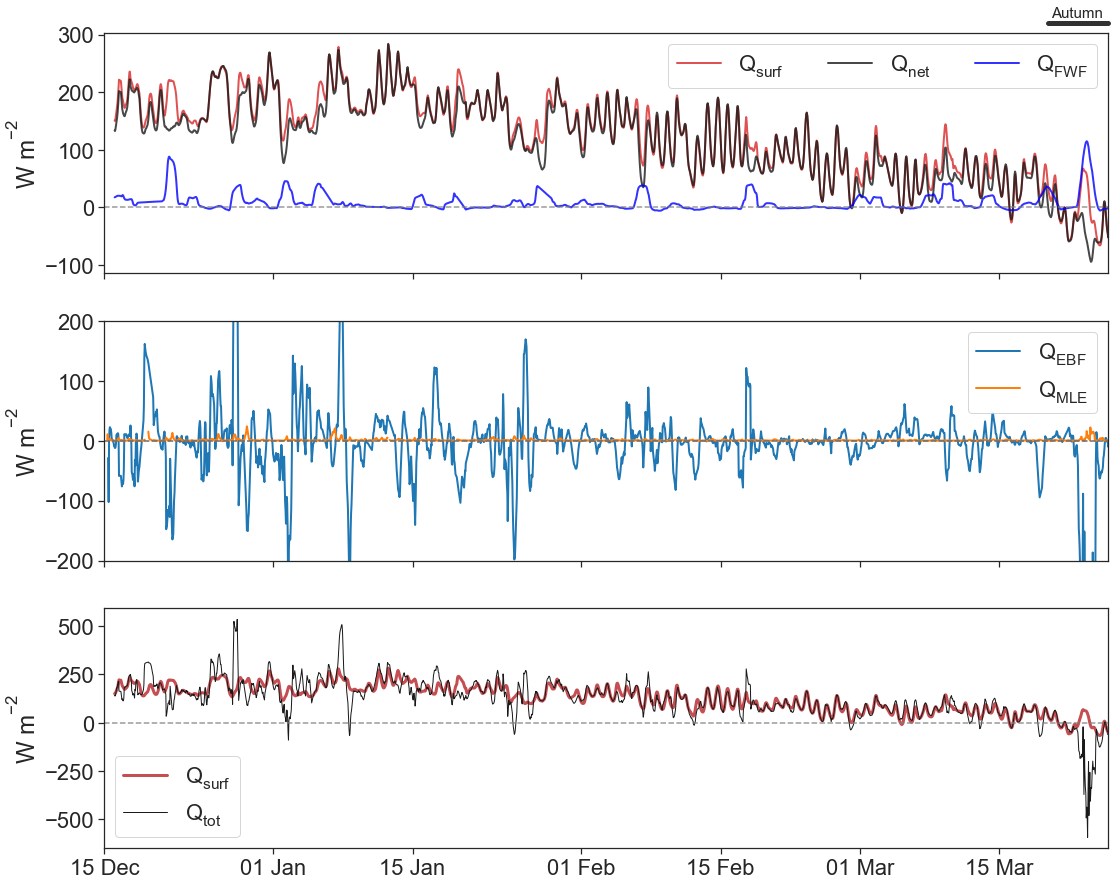

In [413]:
# Plot all
fig,ax=plt.subplots(3,1,figsize=[18,15],sharex=True)
sns.set(font_scale=2)


sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class

#heat flux
Qsurf = pd.Series(Qnet_F).interpolate() + pd.Series(Qnet_interp).interpolate()

ax[0].plot(time,pd.Series(Qsurf).rolling(24).mean(),label='Q$_{surf}$',c='tab:red',alpha=0.8,linewidth=2)
ax[0].plot(time,pd.Series(Qnet_interp).rolling(24).mean(),label='Q$_{net}$',c='k',alpha=0.8,linewidth=2)#ax[0].plot(time, Qfwf_interp,label='Q$_{latent}$',alpha=0.8,linewidth=3)
ax[0].plot(time,pd.Series(Qnet_F).rolling(24).mean().interpolate(),label='Q$_{FWF}$',alpha=0.8,linewidth=2,c='blue')

ax[0].set_ylabel('W m$^{-2}$')

ax[0].legend(ncol=3)
ax[0].axhline(0,linestyle='--',c='Grey',alpha=0.8)

# SMS
ax[1].plot(time.iloc[:-1],pd.Series(ebf).rolling(10).mean().interpolate(),c='tab:blue',linewidth=2,label='Q$_{EBF}$')
ax[1].plot(time.iloc[:-1],Qmle,c='tab:orange',linewidth=2,label='Q$_{MLE}$')


ax[1].axhline(0,c='k',linestyle='--',alpha=0.5)
ax[1].set_ylim(-200,200)
ax[1].set_ylabel('W m$^{-2}$')

Qtot=pd.Series(pd.Series(ebf).rolling(10).mean().interpolate()+Qmle+pd.Series(Qsurf).rolling(24).mean()).interpolate()
ax[1].legend()
ax[1].axhline(0,linestyle='--',c='Grey',alpha=0.8)

# SMS plus atmospheric
ax[2].plot(time,pd.Series(Qsurf).rolling(24).mean(),c='r',linewidth=3,label='Q$_{surf}$')


ax[2].plot(time,Qtot,c='k',linewidth=1,label='Q$_{tot}$')
ax[2].set_xlim(time.iloc[0],time.iloc[-1])
ax[2].legend()
ax[2].set_ylabel('W m$^{-2}$')

ax[2].axhline(0,linestyle='--',c='Grey',alpha=0.8)

a=pd.to_datetime(np.array(time[1954:-1]))
x,y = np.array([[(a[0]), (a[-1])], [320, 320]])
line = lines.Line2D(x, y, lw=5., color='k', alpha=0.9)
ax[0].add_line(line)
line.set_clip_on(False)


ax[0].text(a[5],330,'Autumn',fontsize=15)


h_fmt= mdates.DateFormatter('%d %b')
ax[2].xaxis.set_major_formatter(h_fmt)

plt.savefig('figures/sg643_sms_fluxes_all.png',bbox_inches='tight',dpi=75)



### bx and ebf underestimation analysis

Assume front is oriented north south such that direction of geostrophic shear is east west.   
For glider to sample the front perpendicularly, the glider should be angled north south to capture the full horizontal gradient(i.e. 0). Assume that bx is computed over 1000m = 1e-7. Use all the acute angles of the glider, we can compute the theoretical observed distance across the front and from this estimate how much the glider is underestimating the lateral gradients. 


In [ ]:
o=1000
theta = np.abs(glider_dir)
theta_allpossibilities = np.linspace(1,90,len(glider_dir))
bactual=1e-4/1000 # if glider is perpendicular to front (equivalent to 0degrees here)
bobs=[]
for i in range(len(theta[:])):
    if theta[i]<90:
        h=o/np.cos(np.deg2rad(theta[i]))
        bobs.append(1e-4/h)
    else:
        theta2 = 180-theta[i]
        h=o/np.cos(np.deg2rad(theta2))
        bobs.append(1e-4/h)

ballposs=[]
for i in range(len(theta_allpossibilities[:])):

        h=o/np.sin(np.deg2rad(theta_allpossibilities[i]))
        ballposs.append(1e-4/h)


In [ ]:
allpossiblewindangles=np.linspace(-180,180,len(glider_dir))
windangle=np.ones(len(glider_dir))*0
perpAngle=np.ones(len(glider_dir))*180
actualwindangles=wind_dir_interp[:-1]
windsorted=(actualwindangles)

txt=np.ones(len(glider_dir))*0.1
tyt=np.ones(len(glider_dir))*0.1

ebf_actual,_=sms_fluxes.calc_ebf(1e-7,np.abs(actualwindangles),np.ones(len(glider_dir))*180,txt,tyt,f,5e-5,cp=4000,g=9.8)

#ebf_actual,_=sms_fluxes.calc_ebf(1e-7,[270,270],[90,90],
 #                         [0.1,0.1],[0.1,0.1],f,5e-5,cp=4000,g=9.8)
ebf_obs,_=sms_fluxes.calc_ebf(1e-7,np.abs(actualwindangles),np.abs((glider_dir)),
                          txt,tyt,f,5e-5,cp=4000,g=9.8)

In [ ]:
import seaborn as sns
sns.distplot(np.ma.masked_invalid((ebf_obs[:]))/ebf_actual)
#plt.xlim(-10,10)

In [ ]:
plt.plot(np.sort(ebf_obs))
plt.plot(np.sort(ebf_actual))

In [ ]:
import sklearn.metrics
import math
mse = sklearn.metrics.mean_squared_error( np.sort(bobs),np.ones(len(bobs))*1e-7)
print(mse)
rmse = math.sqrt(mse)
print(rmse)
print(np.nanmean(rmse/1e-7))

In [ ]:
mse = sklearn.metrics.mean_squared_error((ebf_obs),(ebf_actual))
#rint(mse)
print(rmse)
print(np.sort(ebf_actual))
print(np.sort(ebf_obs))
print(np.nanmean(rmse/np.nanmean(ebf_actual)))
#1-0.43

## Spectra Analysis

This whole section needs to be cleaned up

In [1917]:
from spectrum import *
from JD_multitaper import JD_spectra
from scipy.fftpack import fft
from scipy import signal
from JD_multitaper import JD_space_spectra, plot_slope, plot_ref_slope
from scipy import stats

def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

In [1918]:
# Compute spectra for ~20 km transects only, skipping the longer transects 

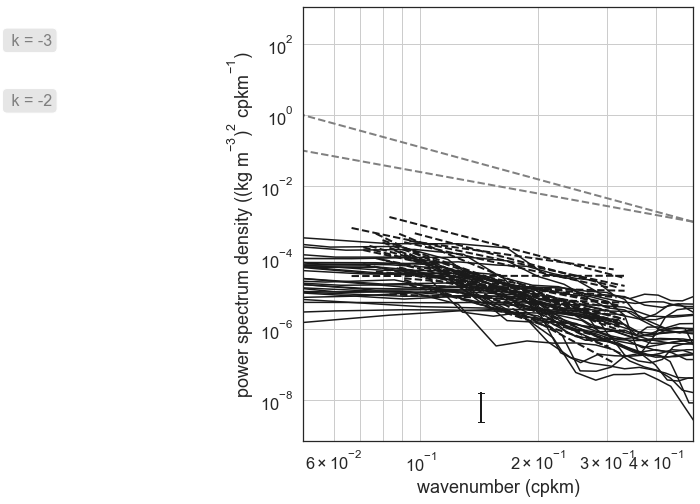

In [1919]:
fig,ax=plt.subplots(figsize=[7,8])

Px_r_short = np.zeros([33,40])

F_r_short =np.zeros([33,40])

Pxc_short = []

hh_short = []

slope_short = []

slope_ci_short = []

barm=[]
barmx=[]

for i in (np.arange(3,33,1)):

   # Fs=1.4
    n = len(df.rho[trans==i])
    #compute power spectrum using scipy.welch
    h_detrended = detrend(df.rho[trans==i]) # detrend
    winweights = quadwin(n) # filter
    h_win_r = h_detrended * winweights
    
    [Px_r3,F_r3,Pxc,hh]=JD_space_spectra(h_win_r, dl=1,
        ax=ax,
        f=1, nw=3, unit='(kg m$^{-3}$)$^2$')
    Px_r3=(np.pad(Px_r3, [(0, 40-len(Px_r3))], mode='constant', constant_values=np.nan))
    F_r3=(np.pad(F_r3, [(0, 40-len(F_r3))], mode='constant', constant_values=np.nan))


    Px_r_short[i,:]=Px_r3
    F_r_short[i,:]=F_r3

    Pxc_short.append(Pxc)
    hh_short.append(hh)

    ref_slopes=[2,3]
    plt.xlim(0.5e-1,0.5)
    sl,_,ci=plot_slope(Px_r3,F_r3,ax=ax,fmin=1/15,fmax=1/3)
    
    slope_short.append(sl)
    slope_ci_short.append(ci)
    barmax=Pxc[0,0]*0.5e-8
    barmin=Pxc[1,0]*0.5e-8
    
    barm.append(Pxc[0,0]*0.5e-8)
    barmx.append(Pxc[1,0]*0.5e-8)
    
    f=1/7
    ax.loglog([f, f],[barmin, barmax],color='k',marker='_')
    
plot_ref_slope(fmin=5e-1,fmax=10**-2,f=10**-3,ax=ax,col='Gray',kvec=ref_slopes)

Px_r_short[Px_r_short==0] = np.nan

F_r_short[F_r_short==0]=np.nan


slope_short = np.array(slope_short)

slope_ci_short = np.array(slope_ci_short)


26
43
32
35
31
30
25
35
20
39
35


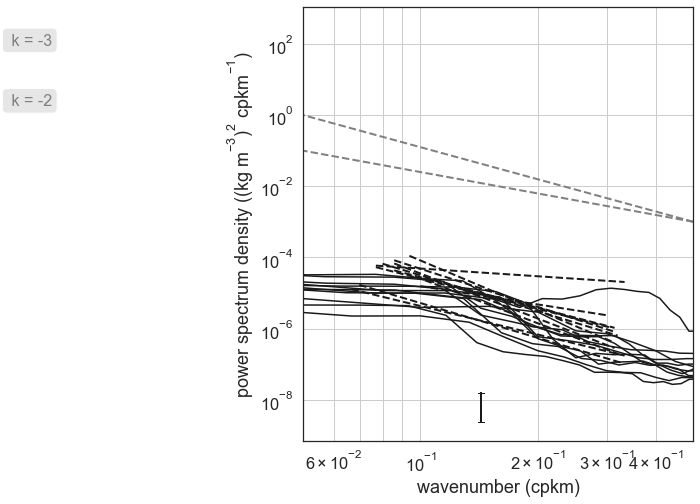

In [1920]:
fig,ax=plt.subplots(figsize=[7,8])

Px_r_short2 = np.zeros([54,40])

F_r_short2 =np.zeros([54,40])

Pxc_short2 = []

hh_short2 = []

slope_short2 = []

slope_ci_short2 = []

barm=[]
barmx=[]

for i in (np.arange(42,53,1)):


   # Fs=1.4
    n = len(df.rho[trans==i])
    print(n)
    #compute power spectrum using scipy.welch
    h_detrended = detrend(df.rho[trans==i]) # detrend
    winweights = quadwin(n) # filter
    h_win_r = h_detrended * winweights
    
    [Px_r3,F_r3,Pxc,hh]=JD_space_spectra(h_win_r, dl=1,
        ax=ax,
        f=1, nw=3, unit='(kg m$^{-3}$)$^2$')
    Px_r3=(np.pad(Px_r3, [(0, 40-len(Px_r3))], mode='constant', constant_values=np.nan))
    F_r3=(np.pad(F_r3, [(0, 40-len(F_r3))], mode='constant', constant_values=np.nan))


    Px_r_short2[i,:]=Px_r3
    F_r_short2[i,:]=F_r3

    Pxc_short2.append(Pxc)
    hh_short2.append(hh)

    ref_slopes=[2,3]
    plt.xlim(0.5e-1,0.5)
    sl,_,ci=plot_slope(Px_r3,F_r3,ax=ax,fmin=1/15,fmax=1/3)
    
    slope_short2.append(sl)
    slope_ci_short2.append(ci)
    barm.append(Pxc[0,0]*0.5e-8)
    barmx.append(Pxc[1,0]*0.5e-8)
    
    f=1/7
    ax.loglog([f, f],[barmin, barmax],color='k',marker='_')
    
plot_ref_slope(fmin=5e-1,fmax=10**-2,f=10**-3,ax=ax,col='Gray',kvec=ref_slopes)

Px_r_short2[Px_r_short2==0] = np.nan

F_r_short2[F_r_short2==0]=np.nan


slope_short2 = np.array(slope_short2)

slope_ci_short2 = np.array(slope_ci_short2)

In [1921]:
#take average confidence interval between all 20 km transects
barm=np.array(barm)
barmx=np.array(barmx)

In [1922]:
b1=(plot_slope(np.nanmean(Px_all[0:12,:18],axis=0),np.nanmean(F_all[0:12,:18],axis=0),ax=ax,fmin=1/20,fmax=1/3)[0])
b2=(plot_slope(np.nanmean(Px_all[0:12,:18],axis=0),np.nanmean(F_all[0:12,:18],axis=0),ax=ax,fmin=1/20,fmax=1/1)[0])
b3=(plot_slope(np.nanmean(Px_all[0:12,:18],axis=0),np.nanmean(F_all[0:12,:18],axis=0),ax=ax,fmin=1/20,fmax=1/2)[0])
b4=(plot_slope(np.nanmean(Px_all[0:12,:18],axis=0),np.nanmean(F_all[0:12,:18],axis=0),ax=ax,fmin=1/19,fmax=1/3)[0])
b5=(plot_slope(np.nanmean(Px_all[0:12,:18],axis=0),np.nanmean(F_all[0:12,:18],axis=0),ax=ax,fmin=1/18,fmax=1/3)[0])
b6=(plot_slope(np.nanmean(Px_all[0:12,:18],axis=0),np.nanmean(F_all[0:12,:18],axis=0),ax=ax,fmin=1/15,fmax=1/3)[0])
#b7=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/80,fmax=1/3)[0])
#b8=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/90,fmax=1/3)[0])

slopes3 = (np.array([b1,b2,b3,b4,b5,b6]))

means3 = np.nanmean(slopes3)

print('mean slope early summer:',np.nanmean(slopes3))
print('standard deviation slope early summer:',np.nanstd(slopes3))

b1=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/20,fmax=1/3)[0])
b2=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/20,fmax=1/1)[0])
b3=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/20,fmax=1/2)[0])
b4=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/19,fmax=1/3)[0])
b5=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/18,fmax=1/3)[0])
b6=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/15,fmax=1/3)[0])
#b7=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/80,fmax=1/3)[0])
#b8=(plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax,fmin=1/90,fmax=1/3)[0])

print(b4)
slopes3 = (np.array([b1,b2,b3,b4,b5,b6]))

means3 = np.nanmean(slopes3)

print('mean slope late summer:',np.nanmean(slopes3))
print('standard deviation slope late summer:',np.nanstd(slopes3))

mean slope early summer: -2.136377588828639
standard deviation slope early summer: 0.0773093729873022
-3.009674384699009
mean slope late summer: -3.0745905616140754
standard deviation slope late summer: 0.09180533781069868


M1 (-2.0426382530853924, -2.0426382530853915, 0.30052286912662085)
M2 (-2.6133463655515725, -2.6133463655515734, 0.23283326629225035)


<ipython-input-1923-3e3570fd47d9>:21: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(1e-2,0)
<ipython-input-1923-3e3570fd47d9>:45: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(1e-2,0)


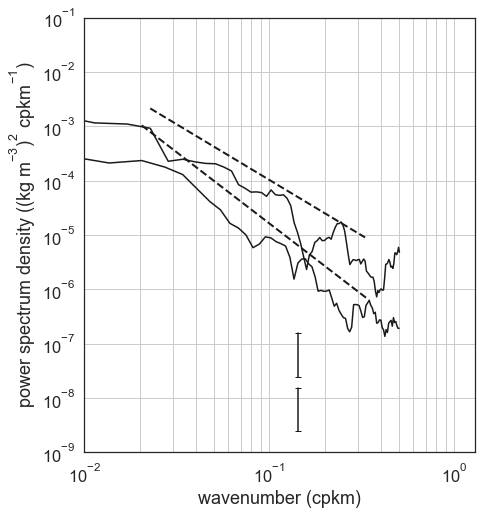

In [1923]:

fig,ax=plt.subplots(figsize=[7,8])
plt.rcParams.update({'font.size': 16})

#####################################################
#####################################################

#### M1
rhoA=pd.Series(df.rho[trans==1])    # Select mean of 10-30m
rhoA=rhoA.interpolate()
n = len(rhoA[:]) 
h_detrended = detrend(rhoA[:])   # detrend 
winweights = quadwin(n)   # filter with a welch window
h_win_r = h_detrended * winweights

[Px_r,F_r,Pxc,hh]=JD_space_spectra(h_win_r, dl=1,
        ax=ax,
        f=1, nw=3, unit='(kg m$^{-3}$)$^2$')


ref_slopes=[2,3]
plt.xlim(1e-2,0)
plt.ylim(1e-9,1e-1)
print('M1',plot_slope(Px_r,F_r,ax=ax,fmin=1/50,fmax=1/3))
#barmax=Pxc[0,0]*0.5e-8
#barmin=Pxc[1,0]*0.5e-8
#f=1/70
ax.loglog([f, f],[barmin, barmax],color='k',marker='_')


#############################################

#### M2
rho3=df.rho[trans==36]    # Select mean of 10-30m
rho3=rho3.interpolate()
n = len(rho3[:]) 
h_detrended = detrend(rho3[:])   # detrend 
winweights = quadwin(n)   # filter with a welch window
h_win_r = h_detrended * winweights

[Px_r2,F_r2,Pxc2,hh]=JD_space_spectra(h_win_r, dl=1,
        ax=ax,
        f=1, nw=3, unit='(kg m$^{-3}$)$^2$')

ref_slopes=[2,3]
plt.xlim(1e-2,0)
plt.ylim(1e-9,1e-1)
print('M2',plot_slope(Px_r2,F_r2,ax=ax,fmin=1/50,fmax=1/3))
barmax=Pxc[0,0]*0.5e-7
barmin=Pxc[1,0]*0.5e-7
#f=1/70
ax.loglog([f, f],[barmin, barmax],color='k',marker='_')

#print(np.nanmean(Pxc[0]))


In [1924]:
# Sensitivity analysis of the choice of slope for M1

a1=(plot_slope(Px_r,F_r,ax=ax,fmin=1/50,fmax=1/3)[0])
a2=(plot_slope(Px_r,F_r,ax=ax,fmin=1/50,fmax=1/4)[0])
a3=(plot_slope(Px_r,F_r,ax=ax,fmin=1/50,fmax=1/5)[0])
a4=(plot_slope(Px_r,F_r,ax=ax,fmin=1/50,fmax=1/7)[0])
a5=(plot_slope(Px_r,F_r,ax=ax,fmin=1/60,fmax=1/3)[0])
a6=(plot_slope(Px_r,F_r,ax=ax,fmin=1/70,fmax=1/3)[0])
a7=(plot_slope(Px_r,F_r,ax=ax,fmin=1/80,fmax=1/3)[0])
a8=(plot_slope(Px_r,F_r,ax=ax,fmin=1/90,fmax=1/3)[0])

slope1 = np.array([a1,a2,a3,a4,a5,a6,a7,a8])

means1 = np.nanmean(slope1)

print('mean slope M1:',np.nanmean(slope1))
print('standard deviation slope M1:',np.nanstd(slope1))

mean slope M1: -2.012460879299902
standard deviation slope M1: 0.15378669193361807


In [1925]:
# Sensitivity analysis of the choice of slope for M2

b1=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/50,fmax=1/3)[0])
b2=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/50,fmax=1/4)[0])
b3=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/50,fmax=1/5)[0])
b4=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/50,fmax=1/7)[0])
b5=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/60,fmax=1/3)[0])
b6=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/70,fmax=1/3)[0])
b7=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/80,fmax=1/3)[0])
b8=(plot_slope(Px_r2,F_r2,ax=ax,fmin=1/90,fmax=1/3)[0])

slopes2 = (np.array([b1,b2,b3,b4,b5,b6,b7,b8]))

means2 = np.nanmean(slopes2)

print('mean slope M2:',np.nanmean(slopes2))
print('standard deviation slope M2:',np.nanstd(slopes2))

mean slope M2: -2.522649618426253
standard deviation slope M2: 0.08701190328872106


In [1926]:
# Hack on slope functions to replace with the mean slopes as computed above. In paper I elected to use
# the confidence interval of just the 3-50km slope for simplicity, but it does not adjust the results too much.   


def plot_slope1(Px,F,ax,fmin=None,fmax=None,col='k',lin='--',lw=2,offy=1):

    """ This function draws the slope of the spectrum
    Arguments:
    Px=the vector of spectrum
    F=the vector of frequency
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    fmin=None (if fmin=None, takes the min of F): frequency minimum where the slope is computed
    fmax=None (if fmax=None, takes the max of F): frequency maximum where the slope is computed
    col='k': color of the slope
    lin='--': linestyle of the slope
    lw=2: linewidth of the slope
    offy=1: y offset of the slope
    
    Outputs:
    The value of the slope

    Author: Nicolas Barrier
    """

    if fmin==None:
        fmin=F.min()
    if fmax==None:
        fmax=F.max()

    i=np.nonzero((F>=fmin)&(F<=fmax)&(F!=0))[0]
    fout=F[i]
    pxout=Px[i]

    y=np.log(pxout)
    x=np.log(fout)
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    confidence_interval = 2.58*std_err #99%
    
    p=np.polyfit(x,y,1)
    
    
   # trend=np.exp(p[0]*x+p[1]+offy)
    trend=np.exp(means2*x+p[1]+offy)


    
    ax.loglog(fout,trend,color=col,linestyle=lin,lw=lw)
    
    
def plot_slope2(Px,F,ax,fmin=None,fmax=None,col='k',lin='--',lw=2,offy=1):

    """ This function draws the slope of the spectrum
    Arguments:
    Px=the vector of spectrum
    F=the vector of frequency
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    fmin=None (if fmin=None, takes the min of F): frequency minimum where the slope is computed
    fmax=None (if fmax=None, takes the max of F): frequency maximum where the slope is computed
    col='k': color of the slope
    lin='--': linestyle of the slope
    lw=2: linewidth of the slope
    offy=1: y offset of the slope
    
    Outputs:
    The value of the slope

    Author: Nicolas Barrier
    """

    if fmin==None:
        fmin=F.min()
    if fmax==None:
        fmax=F.max()

    i=np.nonzero((F>=fmin)&(F<=fmax)&(F!=0))[0]
    fout=F[i]
    pxout=Px[i]

    y=np.log(pxout)
    x=np.log(fout)
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    confidence_interval = 2.58*std_err #99%
    
    p=np.polyfit(x,y,1)
    
    
   # trend=np.exp(p[0]*x+p[1]+offy)
    trend=np.exp(means1*x+p[1]+offy)


    
    ax.loglog(fout,trend,color=col,linestyle=lin,lw=lw)
    




-2.2066293997783153 0.7609616954536819
-2.0817285187694465 0.7357278980329899
-3.009674384699009 1.2549033193864976


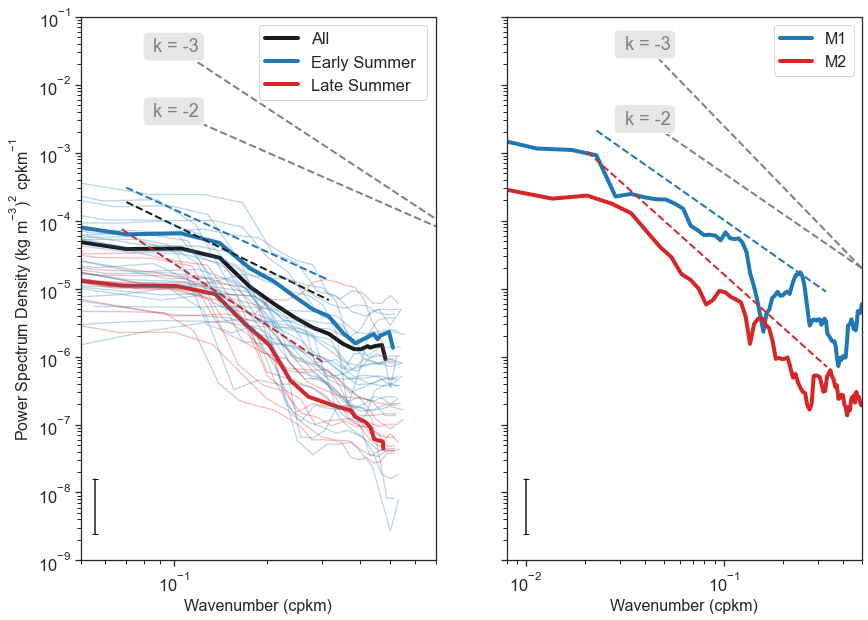

In [1927]:
F_all = np.vstack([F_r_short[3:,:],F_r_short2[42:,:]])
Px_all = np.vstack([Px_r_short[3:,:],Px_r_short2[42:,:]])

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig,ax=plt.subplots(1,2,figsize=[14,10],sharey=True)
sns.set(font_scale=1.5)
sns.set_style('white')


ax[1].loglog(F_r,Px_r,c='tab:blue',linewidth=4,label='M1')


ax[1].loglog(F_r2,Px_r2,c='tab:red',linewidth=4,label='M2')


plot_ref_slope(fmin=5e-1,fmax=1/25,f=2e-5,ax=ax[1],col='Gray',kvec=ref_slopes)



ax[1].legend(fontsize=16)
ax[1].set_xlim(8e-3,5e-1)
ax[1].set_ylim(1.5e-8,1e-1)
barmax=Pxc[0,0]*0.5e-8
barmin=Pxc[1,0]*0.5e-8
f=1/100
ax[1].loglog([f, f],[barmin, barmax],color='k',marker='_')

#############

plot_slope(Px_r2,F_r2,ax=ax[1],fmin=1/50,fmax=1/3,col='tab:red')

############

plot_slope(Px_r,F_r,ax=ax[1],fmin=1/50,fmax=1/3,col='tab:blue')

############################################################################



ax[0].loglog(np.nanmean(F_all[:,:18],axis=0),np.nanmean(Px_all[:,:18],axis=0),c='k',linewidth=4,label='All')

ax[0].loglog(np.nanmean(F_all[:12,:18],axis=0),np.nanmean(Px_all[:12,:18],axis=0),c='tab:blue',linewidth=4,label='Early Summer ')
sl1,_,ci1=plot_slope(np.nanmean(Px_all[:12,:18],axis=0),np.nanmean(F_all[:12,:18],axis=0),ax=ax[0],fmin=1/20,fmax=1/3,col='tab:blue')

ax[0].loglog(np.nanmean(F_all[30:39,:18],axis=0),np.nanmean(Px_all[30:39,:18],axis=0),c='tab:red',linewidth=4,label='Late Summer')
sl2,_,ci2=plot_slope(np.nanmean(Px_all[30:39,:18],axis=0),np.nanmean(F_all[30:39,:18],axis=0),ax=ax[0],fmin=1/20,fmax=1/3,col='tab:red')
sl,_,ci=plot_slope(np.nanmean(Px_all[:,:18],axis=0),np.nanmean(F_all[:,:18],axis=0),ax=ax[0],fmin=1/20,fmax=1/3,col='k')


for i in range(len(F_all[:30])):
    ax[0].loglog(F_all[:30][i],Px_all[:30][i],c='tab:blue',alpha=0.3,linewidth=1.3)


for i in range(len(F_all[30:])):
    ax[0].loglog(F_all[30:][i],Px_all[30:][i],c='tab:red',alpha=0.3,linewidth=1.3)

ax[0].legend()

print(sl,ci)
print(sl1,ci1)
print(sl2,ci2)

barmax=Pxc[0,0]*0.5e-8
barmin=Pxc[1,0]*0.5e-8

f=1/18
ax[0].loglog([f, f],[np.nanmean(barm), np.nanmean(barmx)],color='k',marker='_')

plot_ref_slope(fmin=9e-1,fmax=1/10,f=5e-5,ax=ax[0],col='Gray',kvec=ref_slopes)


ax[0].set_xlim(1/20,7e-1)
ax[0].set_ylim(1e-9,1e-1)

ax[0].set_xlabel('Wavenumber (cpkm)',fontsize=16)
ax[1].set_xlabel('Wavenumber (cpkm)',fontsize=16)


ax[0].set_ylabel('Power Spectrum Density (kg m$^{-3}$)$^2$ cpkm$^{-1}$',fontsize=16)

plt.savefig('figures/power_spectra2.png',transparent=True,dpi=150,bbox_inches='tight')

## Spice analysis

We suspect little vertical exchange across the thermocline in this region.  
This is associated with increased stratification by sea ice melt water. 
i.e. MLE are confined to the ML.  
Here, this hypothesis is tested

In [309]:
# First call regridded data along isopycnals
ds_iso = cat.sg643_density_levels.read()

In [310]:
ds_iso = xr.open_dataset('data/sg643/sg643_grid_density_surfaces.nc')

In [311]:
ds_iso

<xarray.Dataset>
Dimensions:                (density: 99, distance: 2075)
Coordinates:
  * density                (density) float64 1.027e+03 1.027e+03 ... 1.028e+03
  * distance               (distance) int64 0 1000 2000 ... 2073000 2074000
Data variables:
    lat                    (density, distance) float64 ...
    lon                    (density, distance) float64 ...
    time                   (density, distance) datetime64[ns] ...
    salinity               (density, distance) float64 ...
    sea_water_temperature  (density, distance) float64 ...
    depth                  (density, distance) float64 ...
Attributes:
    processing:  This data has been cleaned, interpolated first onto equal de...

In [312]:
spice_iso=gsw.spiciness0(ds_iso.salinity,ds_iso.sea_water_temperature)  # Compute spiciness along isopycnals

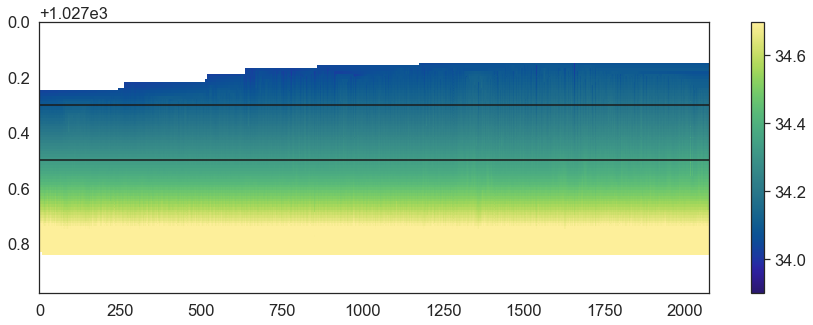

In [314]:
# Look at salinity by density surfaces
xx,yy=np.meshgrid(ds_iso.distance/1000,ds_iso.density)
plt.figure(figsize=[15,5])
plt.pcolormesh(xx,yy,ds_iso.salinity,vmin=33.9,vmax=34.7,cmap=cmo.haline) # blues are the ML
plt.axhline(1027.3,c='k')
plt.axhline(1027.5,c='k')


plt.ylim(ds_iso.density.max(),ds_iso.density.min())
plt.colorbar()

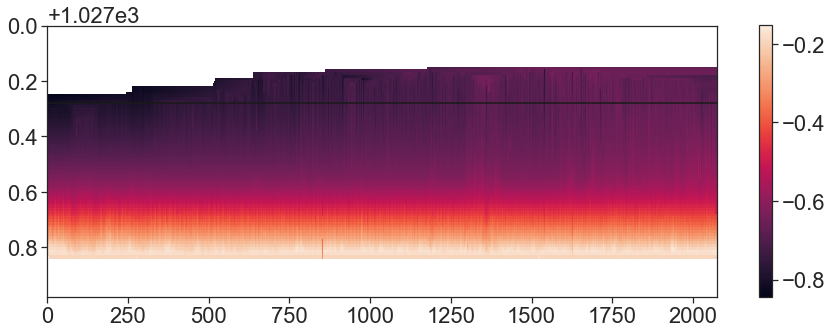

In [53]:
#Spiciness
xx,yy=np.meshgrid(ds_iso.distance/1000,ds_iso.density)
plt.figure(figsize=[15,5])
plt.pcolormesh(xx,yy,spice_iso) # blues are the ML
plt.ylim(ds_iso.density.max(),ds_iso.density.min())
plt.colorbar()
plt.axhline(1027.28,c='k')



In [54]:
# Correlation analysis

In [55]:
from scipy import stats
import math

def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf((1 + alpha)/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se
    
    ci = z_to_r(lo) - z_to_r(hi)
    
    # Return a sequence
    return ci



def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    
    """
    
    r = datax.corr(datay.shift(lag))
    
    CI = r_confidence_interval(r, 0.05, n=datax.size)
    
    return r, CI

In [56]:
ML_spice=detrend(pd.Series((spice_iso[28,:])).dropna())

In [57]:
i=60
spice_detrend=detrend(pd.Series(spice_iso[i,:]).dropna())
ccor, CI=crosscorr(ML_spice,spice_detrend)
CI

-0.002752223946457903

In [58]:
ccor = np.ndarray([80])
CI = np.ndarray([80])




for i in range(28,80):
    spice_detrend=detrend(pd.Series(spice_iso[i,:]).dropna())
    ccor[i],CI[i]=crosscorr(ML_spice,spice_detrend)

   # ccor[i]=crosscorr(ML_spice,spice_detrend)



In [59]:
ccor2 = np.ndarray([80])

for i in range(28,80):
    spice_detrend=detrend(pd.Series(spice_iso[i,:]).dropna())
    ccor2[i],_=crosscorr(ML_spice,spice_detrend,lag=2)
  

In [60]:
ccor3 = np.ndarray([80])

for i in range(28,80):
    spice_detrend=detrend(pd.Series(spice_iso[i,:]).dropna())
    ccor3[i],_=crosscorr(ML_spice,spice_detrend,lag=3)
  

In [61]:
ccor5 = np.ndarray([80])

for i in range(28,80):
    spice_detrend=detrend(pd.Series(spice_iso[i,:]).dropna())
    ccor5[i],_=crosscorr(ML_spice,spice_detrend,lag=5)
  

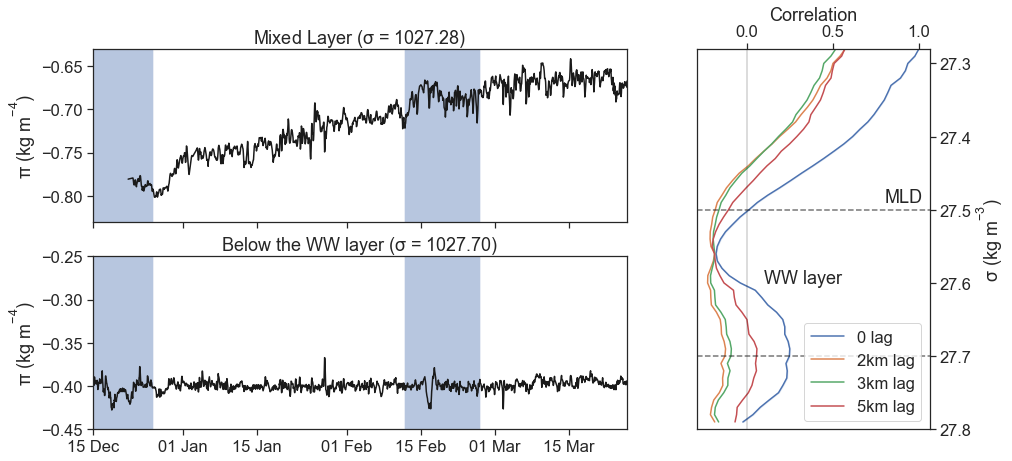

In [62]:
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig = plt.figure(constrained_layout=False,figsize=[15,7])
gs = gridspec.GridSpec(2, 3, figure=fig)
plt.subplots_adjust(wspace=0.3)
ax1 = plt.subplot(gs[0,0:2])
ax2 = plt.subplot(gs[1,0:2])
ax3 = plt.subplot(gs[:,2])


ax1.plot(time[140:],pd.Series(np.ma.masked_invalid(spice_iso[28,140:])).rolling(4).mean(),c='k')
ax1.set_xlim(time[0],time.iloc[-1])

ax1.axvspan(time[0],time[260],alpha=0.4)
ax1.axvspan(time[1280],time[1550],alpha=0.4)
ax1.set_ylim(-0.83,-0.63)

ax2.plot(time[:],pd.Series(spice_iso[70,:]).rolling(4).mean(),c='k')
ax2.set_xlim(time[0],time.iloc[-1])
ax2.set_ylim(-0.45,-0.25)


ax2.axvspan(time[0],time[260],alpha=0.4)
ax2.axvspan(time[1280],time[1550],alpha=0.4)

ax1.set_title('Mixed Layer ($\sigma$ = 1027.28)')
ax2.set_title('Below the WW layer ($\sigma$ = 1027.70)')


ax1.set_ylabel('$\pi$ (kg $m^{-4})$')
ax2.set_ylabel('$\pi$ (kg $m^{-4})$')



h_fmt= mdates.DateFormatter('%d %b')
ax2.xaxis.set_major_formatter(h_fmt)
ax1.set_xticklabels([])



ax3.plot(ccor[28:],ds_iso.density[28:80]-1000,label='0 lag')
ax3.fill_betweenx(ds_iso.density[28:80]-1000, (ccor[28:]-CI[28:]), (ccor[28:]+CI[28:]), color='b', alpha=.1)


ax3.plot(ccor2[28:],ds_iso.density[28:80]-1000,label='2km lag')
ax3.plot(ccor3[28:],ds_iso.density[28:80]-1000,label='3km lag')
ax3.plot(ccor5[28:],ds_iso.density[28:80]-1000,label='5km lag')

ax3.legend()

ax3.text(0.8,27.49,'MLD')
ax3.text(0.1,27.6,'WW layer')



ax3.set_ylim(27.8,ds_iso.density[28]-1000)
ax3.axhline(27.5,c='k',linestyle='--',alpha=0.6)
ax3.axhline(27.7,c='k',linestyle='--',alpha=0.6)


ax3.axvline(0,c='k',linestyle='-',alpha=0.2)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('$\sigma$ (kg m$^{-3}$)')

ax3.xaxis.tick_top()
ax3.xaxis.set_label_position("top")
ax3.set_xlabel('Correlation')

plt.savefig('figures/spice_analysis.png',dpi=75,bbox_inches='tight')
